# Models #
- ARIMA
- SARIMA
- SARIMAX
- Gaussian Processes

In [127]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import ARIMA, auto_arima
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import StandardScaler

import GPy

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from typing import Tuple

In [128]:
parquet_directory = '/Users/fionachow/Documents/NYU/CDS/Fall 2024/DS - GA 1018 Probabilistic Time Series/Project/electricity_demand_forecasting/data/'
metadata_file = f'{parquet_directory}/metadata.parquet'
demand_file = f'{parquet_directory}/demand.parquet'
weather_file = f'{parquet_directory}/weather.parquet'

metadata = pd.read_parquet(metadata_file)
demand = pd.read_parquet(demand_file)
weather = pd.read_parquet(weather_file)

**Metadata**
- Time period
- Daily Meter Count

In [129]:
london_data_ids = metadata[metadata['dataset'] == "London Smart Meter Data"]['unique_id'].unique()
london_demand = demand[demand['unique_id'].isin(london_data_ids)]

start_date = london_demand['timestamp'].min()
end_date = london_demand['timestamp'].max()
total_days = (end_date - start_date).days
total_years = total_days / 365

print("London Smart Meter Data:")
print(f"  Start Date: {start_date}")
print(f"  End Date: {end_date}")
print(f"  Total Years: {total_years:.2f}")


London Smart Meter Data:
  Start Date: 2011-11-23 09:00:00
  End Date: 2014-02-28 00:00:00
  Total Years: 2.27


In [4]:
combined_df = pd.merge(demand, metadata, on='unique_id', how='inner')

/var/folders/hb/l21bg8lx3tgc5ky3s56cwdth0000gn/T/ipykernel_27518/1284198705.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_combined_df['date'] = london_combined_df['timestamp'].dt.date


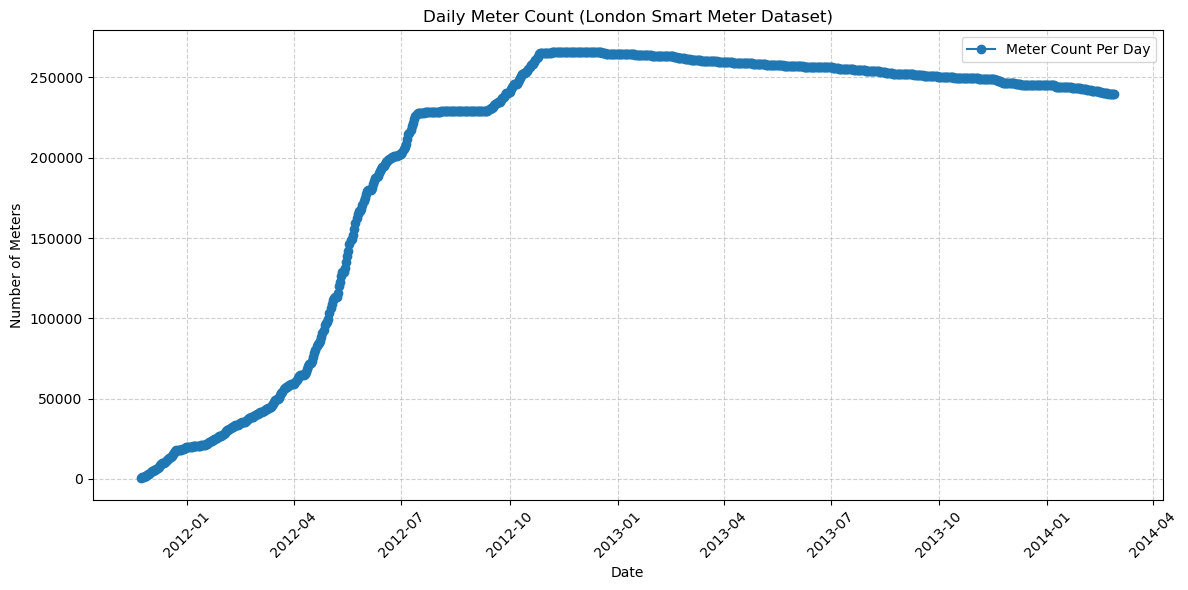

In [10]:
london_combined_df = combined_df[combined_df['dataset'] == 'London Smart Meter Data']

london_combined_df['date'] = london_combined_df['timestamp'].dt.date

daily_meter_count = london_combined_df.groupby('date')['building_id'].count().reset_index()
daily_meter_count.rename(columns={'building_id': 'meter_count'}, inplace=True)

truncated_daily_meter_count = daily_meter_count[daily_meter_count['date'] <= pd.to_datetime('2014-02-27').date()]

plt.figure(figsize=(12, 6))
plt.plot(truncated_daily_meter_count['date'], truncated_daily_meter_count['meter_count'], marker='o', label='Meter Count Per Day')
plt.title("Daily Meter Count (London Smart Meter Dataset)")
plt.xlabel("Date")
plt.ylabel("Number of Meters")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

To address the increasing daily meter count over time, we decided to model the average meter consumption rather than the total meter consumption. This approach normalizes the data by accounting for the varying number of meters, ensuring that the analysis focuses on per-meter consumption trends rather than being skewed by changes in the total number of meters.

**Data Preprocessing:** 
- Focusing on valid 30min offsets
- Aggregating meter data by day
- Averaging meter consumption
- Train/Test Split 80/20


In [130]:
london_demand['timestamp'] = pd.to_datetime(london_demand['timestamp'], errors='coerce')
valid_offsets_set = set(pd.date_range("00:00", "23:59", freq="30T").strftime("%H:%M"))
london_demand['time_offset'] = london_demand['timestamp'].dt.strftime("%H:%M")
london_demand = london_demand[london_demand['time_offset'].isin(valid_offsets_set)]
london_demand = london_demand.drop(columns=['time_offset'])

london_demand['date'] = london_demand['timestamp'].dt.date  

daily_demand = london_demand.groupby('date')['y'].mean().reset_index() 

split_date_daily = daily_demand['date'].min() + 0.8 * (daily_demand['date'].max() - daily_demand['date'].min())
split_date_daily = pd.to_datetime(split_date_daily).date()  

train_data_daily = daily_demand[daily_demand['date'] < split_date_daily]
test_data_daily = daily_demand[daily_demand['date'] >= split_date_daily]


 /var/folders/hb/l21bg8lx3tgc5ky3s56cwdth0000gn/T/ipykernel_30924/3162759261.py:1: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 /var/folders/hb/l21bg8lx3tgc5ky3s56cwdth0000gn/T/ipykernel_30924/3162759261.py:3: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**Visualizing the data to understand:**
- Seasonality
- Order of AR and MA processes
- Stationarity

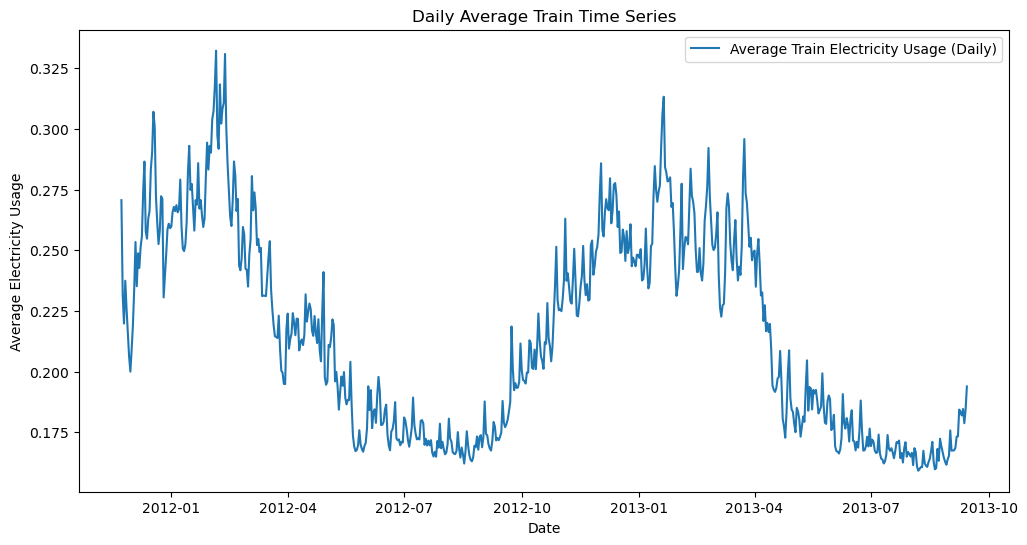

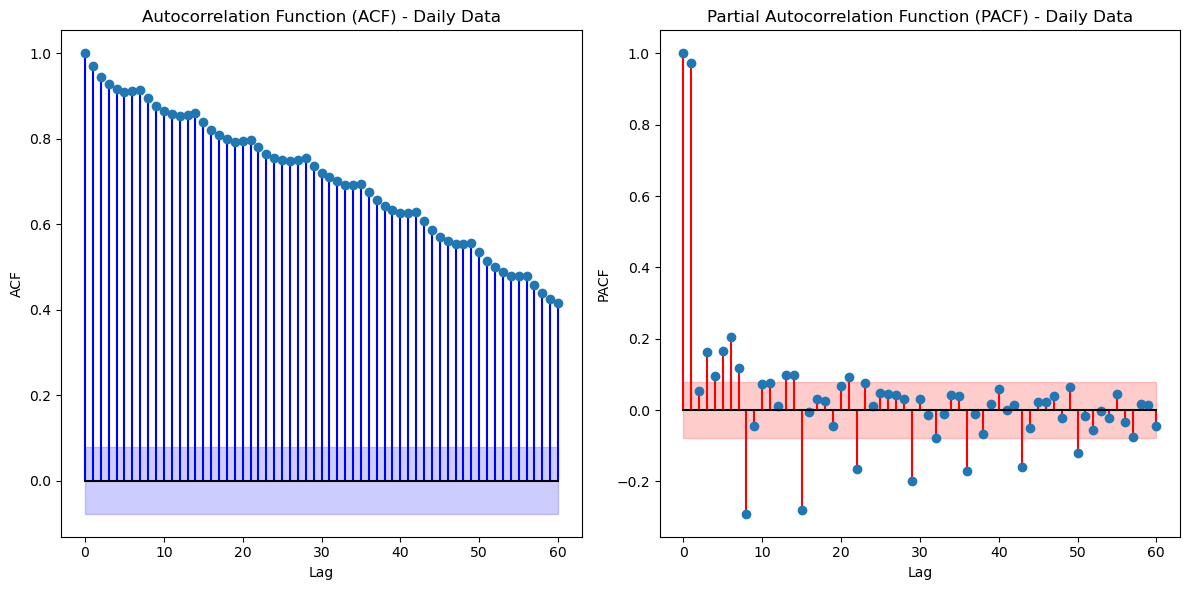

In [141]:
plt.figure(figsize=(12, 6))
plt.plot(train_data_daily['date'], train_data_daily['y'], label='Average Train Electricity Usage (Daily)')
plt.title("Daily Average Train Time Series")
plt.xlabel("Date")
plt.ylabel("Average Electricity Usage")
plt.legend()
plt.show()

train_signal_daily = train_data_daily['y'].to_numpy()

n_lags_daily = 60 
acf_estimate_daily = acf(train_signal_daily, nlags=n_lags_daily)
pacf_estimate_daily = pacf(train_signal_daily, nlags=n_lags_daily)
acf_error_estimate_daily = 2 / np.sqrt(len(train_signal_daily))
pacf_error_estimate_daily = 2 / np.sqrt(len(train_signal_daily))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.stem(range(len(acf_estimate_daily)), acf_estimate_daily, linefmt='b', basefmt='k', use_line_collection=True)
ax1.fill_between(range(len(acf_estimate_daily)), acf_error_estimate_daily, -acf_error_estimate_daily, color='blue', alpha=0.2)
ax1.set_title("Autocorrelation Function (ACF) - Daily Data")
ax1.set_xlabel("Lag")
ax1.set_ylabel("ACF")

ax2.stem(range(len(pacf_estimate_daily)), pacf_estimate_daily, linefmt='r', basefmt='k', use_line_collection=True)
ax2.fill_between(range(len(pacf_estimate_daily)), pacf_error_estimate_daily, -pacf_error_estimate_daily, color='red', alpha=0.2)
ax2.set_title("Partial Autocorrelation Function (PACF) - Daily Data")
ax2.set_xlabel("Lag")
ax2.set_ylabel("PACF")

plt.tight_layout()
plt.show()

The raw data time series exhibits annual seasonality. The ACF indicates a 7-day seasonality without a clear MA process, while the PACF suggests a first-order AR process. Below, we extended the ACF and PACF further to see if we could spot annual seasonality.

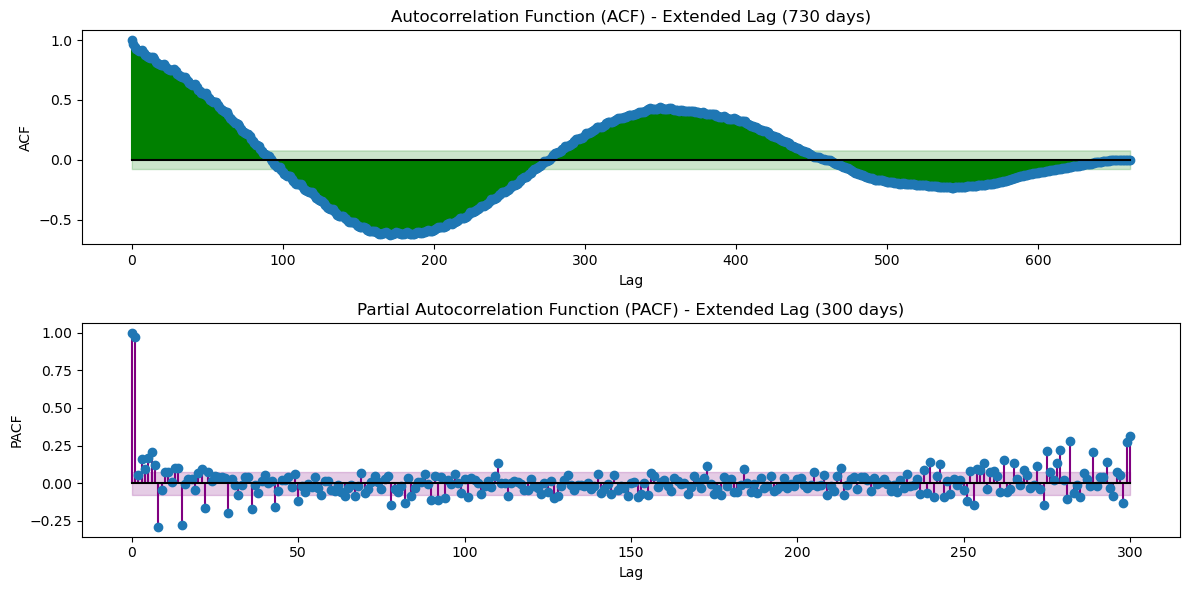

In [142]:
extended_n_lags = int(365 * 2)
extended_n_lags_2 = 300
extended_acf_estimate_daily = acf(train_signal_daily, nlags=extended_n_lags)
extended_acf_error_estimate_daily = 2 / np.sqrt(len(train_signal_daily))

extended_pacf_estimate_daily = pacf(train_signal_daily, nlags=extended_n_lags_2)
extended_pacf_error_estimate_daily = 2 / np.sqrt(len(train_signal_daily))

fig, axes = plt.subplots(2, 1, figsize=(12, 6))

axes[0].stem(range(len(extended_acf_estimate_daily)), extended_acf_estimate_daily, linefmt='g', basefmt='k', use_line_collection=True)
axes[0].fill_between(range(len(extended_acf_estimate_daily)), extended_acf_error_estimate_daily, -extended_acf_error_estimate_daily, color='green', alpha=0.2)
axes[0].set_title(f"Autocorrelation Function (ACF) - Extended Lag ({extended_n_lags} days)")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("ACF")

axes[1].stem(range(len(extended_pacf_estimate_daily)), extended_pacf_estimate_daily, linefmt='purple', basefmt='k', use_line_collection=True)
axes[1].fill_between(range(len(extended_pacf_estimate_daily)), extended_pacf_error_estimate_daily, -extended_pacf_error_estimate_daily, color='purple', alpha=0.2)
axes[1].set_title(f"Partial Autocorrelation Function (PACF) - Extended Lag ({extended_n_lags_2} days)")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("PACF")

plt.tight_layout()
plt.show()

The extended lags of the ACF reveal annual seasonality in the data. We also ran a fourier transform of our raw data to check for seasonality.

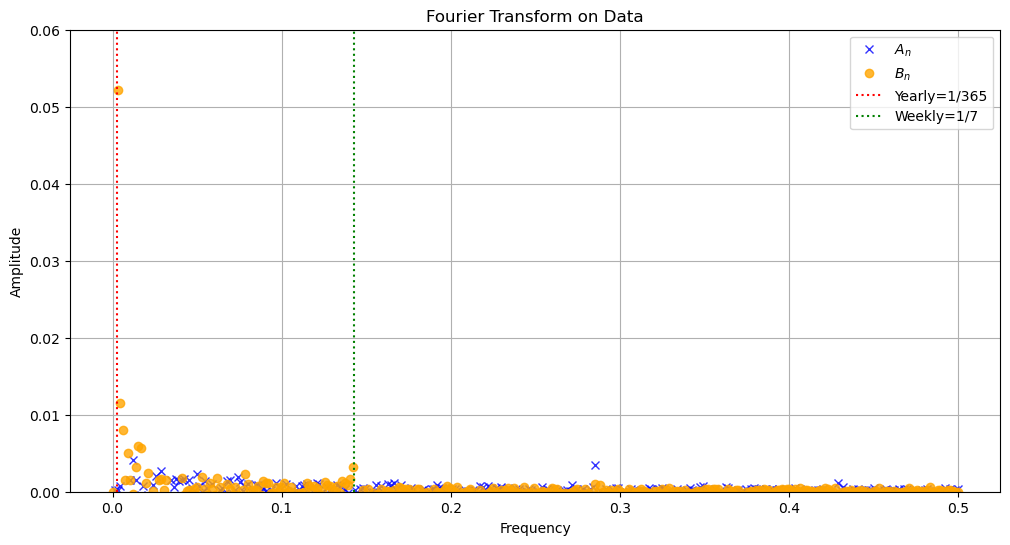

In [143]:
def calculate_fourier_series(
    dt: float, signal: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    frequencies = np.fft.rfftfreq(len(signal), dt)
    fourier_transform = np.fft.rfft(signal, norm='forward')
    a_n = fourier_transform.real * 2
    b_n = -fourier_transform.imag * 2
    return frequencies, a_n, b_n

def fourier_transform_plot(frequencies, a_n, b_n, title):
    plt.figure(figsize=(12, 6))
    plt.plot(frequencies, a_n, 'x', label=r'$A_n$', color='blue', alpha=0.8)
    plt.plot(frequencies, b_n, 'o', label=r'$B_n$', color='orange', alpha=0.8)

    yearly_freq = 1/365
    weekly_freq = 1/7
    plt.axvline(yearly_freq, color='red', linestyle='dotted', label='Yearly=1/365')
    plt.axvline(weekly_freq, color='green', linestyle='dotted', label='Weekly=1/7')
    
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.ylim(0,0.06)
    plt.legend()
    plt.grid()
    plt.show()

dt = 1  

frequencies_data, a_n_data, b_n_data = calculate_fourier_series(dt, train_signal_daily)
fourier_transform_plot(frequencies_data, a_n_data, b_n_data, "Fourier Transform on Data")

The fourier transform further supports that this data has two seasonalities -- weekly and yearly.

Next, we wanted to test for stationarity. So we ran a Augmented Dickey-Fuller (ADF) Test. 

If the p-value is below a threshold (0.05), the series is considered stationary.

In [8]:
adf_test = adfuller(train_signal_daily)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")  

ADF Statistic: -1.744059715001038
p-value: 0.40856637316149313


Given that the p-value is above the threshold, we went ahead to difference the data once.

In [9]:
differenced_series = daily_demand.diff().dropna() 

differenced_train_signal = differenced_series['y'].to_numpy()
adf_test = adfuller(differenced_train_signal)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}") 

ADF Statistic: -6.6753397613307275
p-value: 4.479972536543365e-09


And now the p-value is below the threshold and is considered stationary. This is also visible in the a plot below of the raw data differenced once.

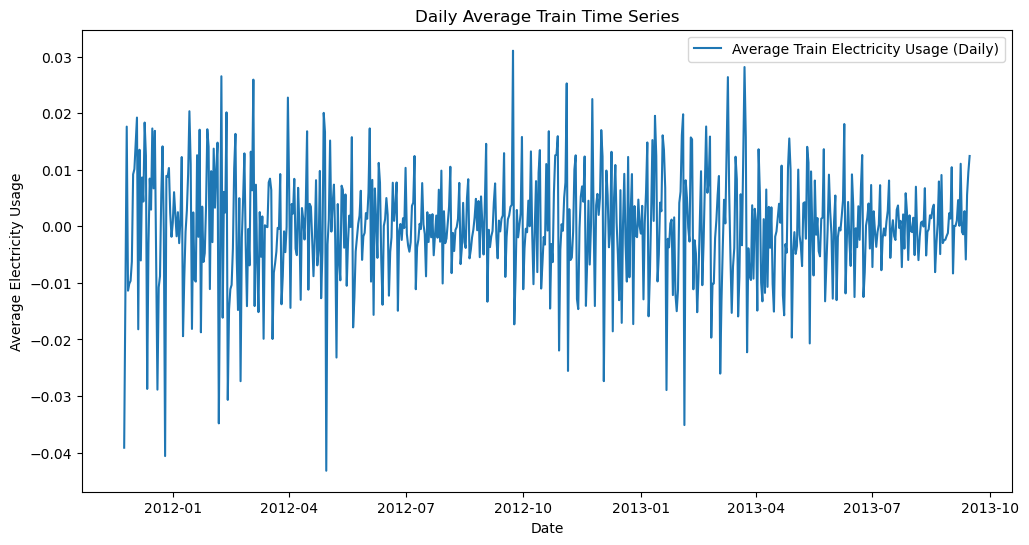

In [10]:
differenced_series = daily_demand[['date']].copy()
differenced_series['y'] = daily_demand['y'].diff()
differenced_series = differenced_series.dropna().reset_index(drop=True)

differenced_series['date'] = pd.to_datetime(differenced_series['date'])

split_date_daily = differenced_series['date'].min() + pd.Timedelta(days=0.8 * (differenced_series['date'].max() - differenced_series['date'].min()).days)
train_data_daily_differenced = differenced_series[differenced_series['date'] < split_date_daily]
test_data_daily_differenced = differenced_series[differenced_series['date'] >= split_date_daily]

plt.figure(figsize=(12, 6))
plt.plot(train_data_daily_differenced['date'], train_data_daily_differenced['y'], label='Average Train Electricity Usage (Daily)')
plt.title("Daily Average Train Time Series")
plt.xlabel("Date")
plt.ylabel("Average Electricity Usage")
plt.legend()
plt.show()

**Modeling**

We started by trying to model ARMA(1,0) based on visual inspection of PACF and ACF of the raw data just as we did in class.

Fitting the ARIMA(1, 0, 0) model on the entire training dataset...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Forecasting...
Evaluation Metrics:
  MAPE: 0.0841
  RMSE: 0.0224
  Log-Likelihood: 2119.1266
  AIC: -4232.2532


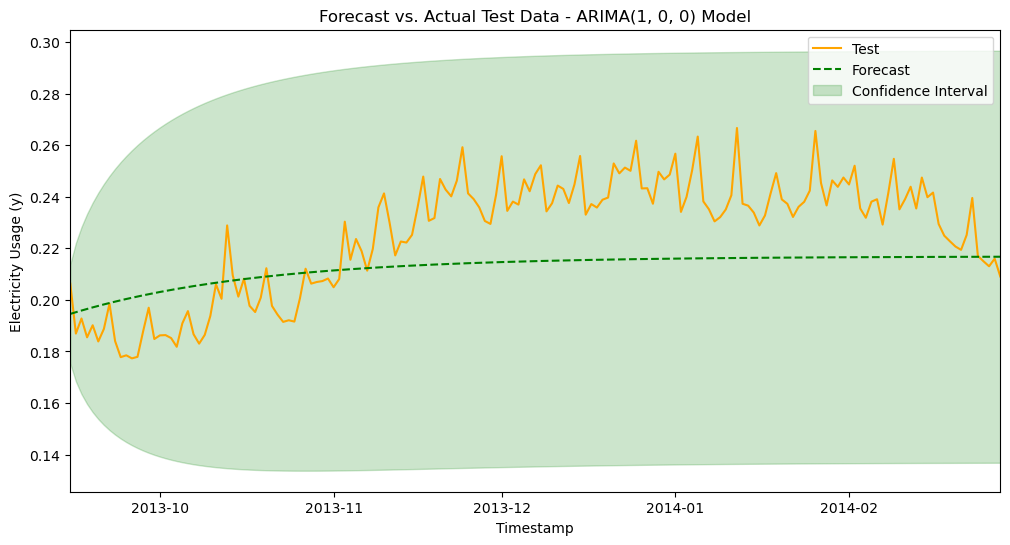

In [137]:
from statsmodels.tsa.arima.model import ARIMA

train_series = train_data_daily.set_index('date')['y']
test_series = test_data_daily.set_index('date')['y']

print("Fitting the ARIMA(1, 0, 0) model on the entire training dataset...")
model = ARIMA(train_series, order=(1, 0, 0))
fitted_model = model.fit()

print("Forecasting...")
forecast_values = fitted_model.forecast(steps=len(test_series))
conf_int = fitted_model.get_forecast(steps=len(test_series)).conf_int()

forecast_values.index = test_series.index
conf_int.index = test_series.index

mape = mean_absolute_percentage_error(test_series, forecast_values)
rmse = np.sqrt(mean_squared_error(test_series, forecast_values))
log_likelihood = fitted_model.llf
aic = fitted_model.aic

print(f"Evaluation Metrics:")
print(f"  MAPE: {mape:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  Log-Likelihood: {log_likelihood:.4f}")
print(f"  AIC: {aic:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_series.index, test_series, label='Test', color='orange')
plt.plot(forecast_values.index, forecast_values, label='Forecast', linestyle='--', color='green')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2, label='Confidence Interval')
plt.title("Forecast vs. Actual Test Data - ARIMA(1, 0, 0) Model")
plt.xlabel("Timestamp")
plt.ylabel("Electricity Usage (y)")
plt.xlim(test_series.index.min(), test_series.index.max())
plt.legend()
plt.show()


We then compared the theoretical ACF of ARMA(1,0) against the estimated ACF computed from the data to see if the ARMA(1,0) model appropriately captures the autocorrelation structure of the data, helping us validate whether it is a good fit or if adjustments to the model parameters are needed.

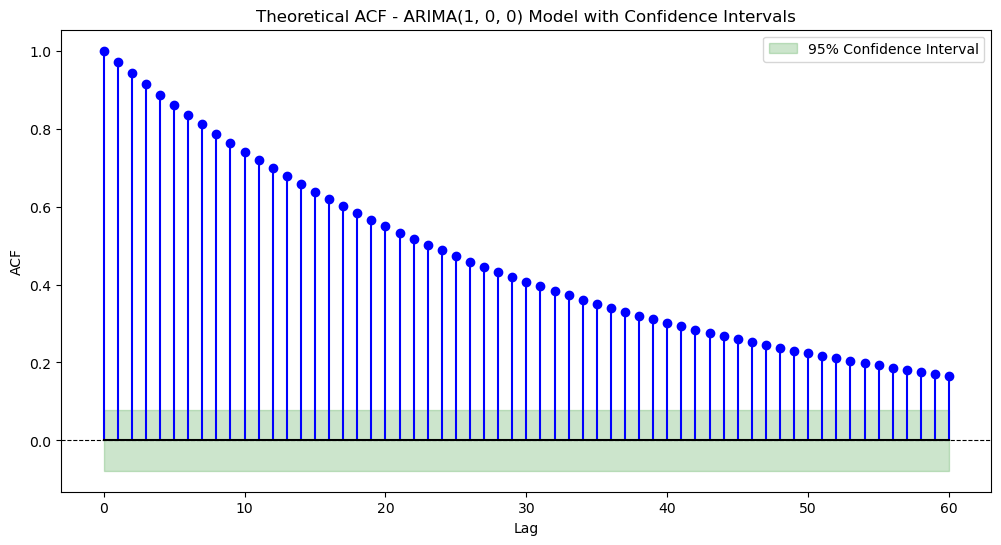

In [138]:
ar_params = fitted_model.arparams 
ma_params = fitted_model.maparams

arma_process = ArmaProcess(np.r_[1, -ar_params], np.r_[1, ma_params])

n_lags = 60
theoretical_acf = arma_process.acf(lags=n_lags + 1)

n_samples = len(train_series)  
conf_interval = 2 / np.sqrt(n_samples)  

plt.figure(figsize=(12, 6))
plt.stem(range(n_lags + 1), theoretical_acf, linefmt='b-', basefmt='k', markerfmt='bo', use_line_collection=True)
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.8)
plt.fill_between(
    range(n_lags + 1), 
    -conf_interval, 
    conf_interval, 
    color='green', alpha=0.2, label="95% Confidence Interval"
)
plt.title("Theoretical ACF - ARIMA(1, 0, 0) Model with Confidence Intervals")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.legend()
plt.show()

And it does look like the theoretical ACF of ARMA(1,0) is similar to the estimated ACF i.e. the model fit is good. In addition, the evaluation metrics for forecasting on unseen data is ~8%. Hence ARMA(1,0) is a good start to modeling the daily average electricity demand of London.

We also performed an automated grid search using AutoARIMA to identify the optimal ARIMA parameters and compared the results to the manually selected ARMA parameters based on visual inspection.

Fitting ARMA model using auto_arima...
Performing stepwise search to minimize aic


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning:stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4221.387, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4220.375, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4220.871, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4223.296, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4251.765, Time=0.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4261.547, Time=0.36 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4236.683, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4241.349, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4253.056, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4166.417, Time=0.31 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4242.304, Time=0.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-4249.523, Time=0.64 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4263.882, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4240.960, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4238.534, Time=0.17

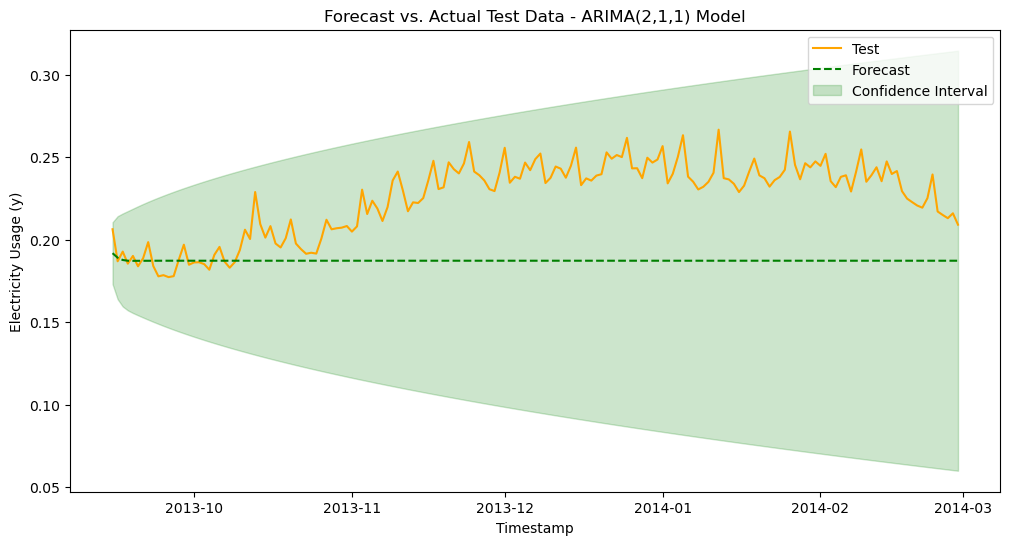

In [52]:
print("Fitting ARMA model using auto_arima...")
arma_model = auto_arima(
    train_series,
    start_p=0, max_p=3,  
    start_q=0, max_q=5,
    seasonal=False,      
    stepwise=True,       
    trace=True,          
    suppress_warnings=True, 
    information_criterion='aic',  
    n_jobs=-1          
)

print(f"Best ARMA model order: {arma_model.order}")

print("Forecasting...")
forecast_values, conf_int = arma_model.predict(n_periods=len(test_series), return_conf_int=True)

mape = mean_absolute_percentage_error(test_series, forecast_values)
rmse = np.sqrt(mean_squared_error(test_series, forecast_values))
aic = arma_model.aic()

print(f"Evaluation Metrics:")
print(f"  MAPE: {mape:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  AIC: {aic:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_series.index, test_series, label='Test', color='orange')
plt.plot(test_series.index, forecast_values, label='Forecast', linestyle='--', color='green')
plt.fill_between(test_series.index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2, label='Confidence Interval')
plt.title("Forecast vs. Actual Test Data - ARIMA(2,1,1) Model")
plt.xlabel("Timestamp")
plt.ylabel("Electricity Usage (y)")
plt.legend()
plt.show()

The parameters chosen by the automated grid search were slightly different at ARIMA(2,1,1). The difference likely arises because the automated grid search is able to consider differencing with AR and MA order terms and optimize for them together, something we are unable to visually pick up when we start considering d = 1 since the data y axis will change and we are not sure how to interpret the ACF and PACF of once differenced data. We will leave a visualization of once differenced ACF and PACF below as a reference of what it looks like. In a similar vein, we plot the theoretical ACF of ARIMA(2,1,1) to compare with the once differenced ACF (estimated ACF) and notice it is not a good fit. Perhaps theoretical ACF of ARIMA(2,1,1) does not work so well in explaining model fit of differenced data.

Additionally, it is interesting to note that auto_arima optimizes for the Akaike Information Criterion (AIC) which balances goodness of fit (measured by log-likelihood) and model complexity (penalizing the number of parameters) on the training dataset. So it focuses on model fit over evaluating forecast performance of unseen data in selecting the best model. In contrast, we prioritized evaluating the model's forecast performance on the test set, using primary metrics such as MAPE, RMSE as our primary goal was to assess predictive accuracy rather than model selection. This is also why auto_arima's best model of ARIMA(2,1,1) had worse (higher) MAPE and RMSE than our visual ARMA(1,0) as it had a better (lower) AIC on train set than our visual ARMA.

Noticeably, the automated grid search did pick up on the data set needing to difference once for stationarity which is similar to what we had seen earlier with the ADF test. So this automated grid search is useful in that it allows us to do more when a model requires more parameter selection such as when differencing is involved and for seasonal parameters in the next steps.

Next we tried to improve the model's evaluation forecast. We noticed that the forecast is flat and not capturing any seasonality and we will attempt to capture it with SARIMA.

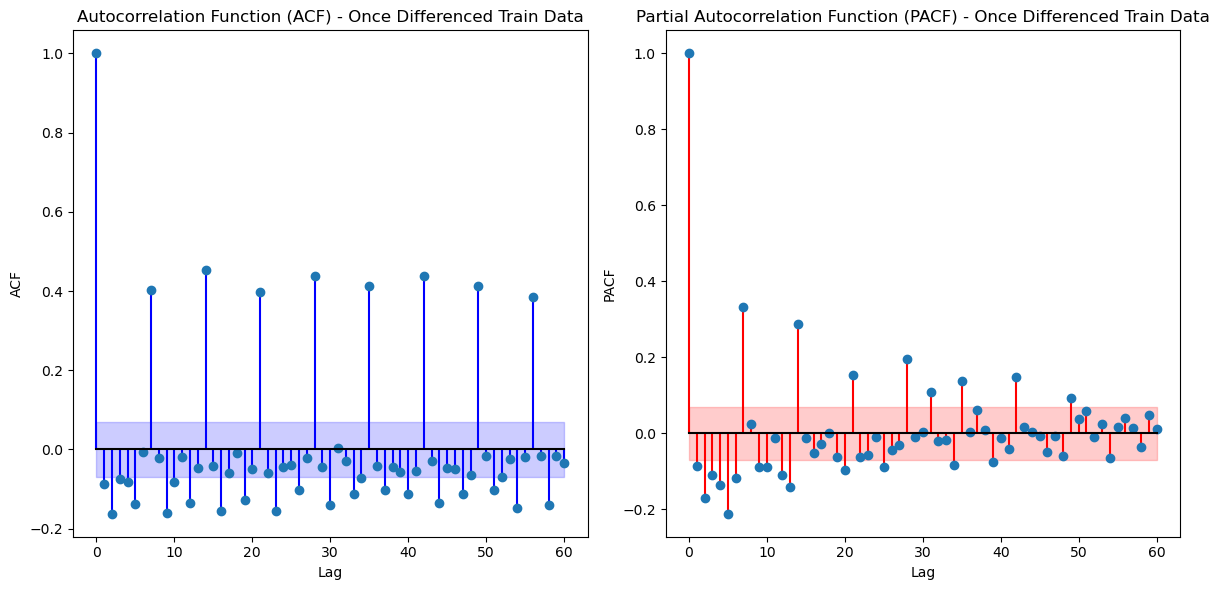

In [144]:
#visualization of once differenced ACF and PACF as mentioned above

differenced_series = daily_demand.copy()
differenced_series['y'] = daily_demand['y'].diff().dropna() 
differenced_series = differenced_series.dropna().reset_index(drop=True) 

train_signal = differenced_series['y'].to_numpy()

n_lags = 60
acf_estimate = acf(train_signal, nlags=n_lags)
pacf_estimate = pacf(train_signal, nlags=n_lags)
acf_error_estimate = 2 / np.sqrt(len(train_signal))  
pacf_error_estimate = 2 / np.sqrt(len(train_signal)) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.stem(range(len(acf_estimate)), acf_estimate, linefmt='b', basefmt='k', use_line_collection=True)
ax1.fill_between(range(len(acf_estimate)), acf_error_estimate, -acf_error_estimate, color='blue', alpha=0.2)
ax1.set_title("Autocorrelation Function (ACF) - Once Differenced Train Data")
ax1.set_xlabel("Lag")
ax1.set_ylabel("ACF")

ax2.stem(range(len(pacf_estimate)), pacf_estimate, linefmt='r', basefmt='k', use_line_collection=True)
ax2.fill_between(range(len(pacf_estimate)), pacf_error_estimate, -pacf_error_estimate, color='red', alpha=0.2)
ax2.set_title("Partial Autocorrelation Function (PACF) - Once Differenced Train Data")
ax2.set_xlabel("Lag")
ax2.set_ylabel("PACF")

plt.tight_layout()
plt.show()

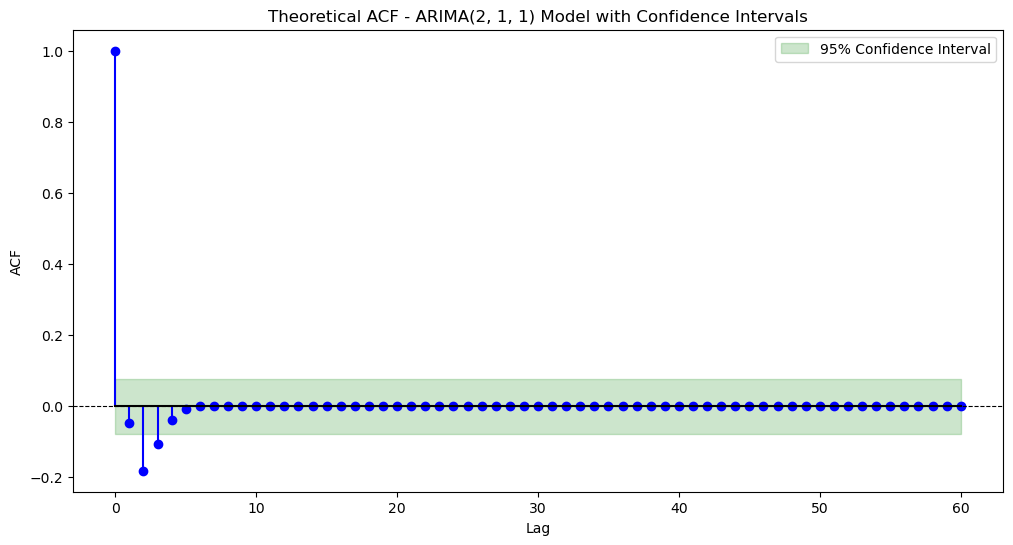

In [145]:
#visualization of theoretical ACF of ARIMA(2,1,1) to compare with estimated ACF of once differenced data above.

ar_params = arma_model.arparams()  
ma_params = arma_model.maparams()   

arma_process = ArmaProcess(np.r_[1, -ar_params], np.r_[1, ma_params])

n_lags = 60  
theoretical_acf = arma_process.acf(lags=n_lags + 1)

n_samples = len(train_series)  
conf_interval = 2 / np.sqrt(n_samples)  

plt.figure(figsize=(12, 6))
plt.stem(range(n_lags + 1), theoretical_acf, linefmt='b-', basefmt='k', markerfmt='bo', use_line_collection=True)
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.8)
plt.fill_between(
    range(n_lags + 1), 
    -conf_interval, 
    conf_interval, 
    color='green', alpha=0.2, label="95% Confidence Interval"
)
plt.title("Theoretical ACF - ARIMA(2, 1, 1) Model with Confidence Intervals")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.legend()
plt.show()

In [89]:
#just to extract log-likelihood that auto_arima package does not have

from statsmodels.tsa.arima.model import ARIMA

print("Fitting the ARIMA(2, 1, 1) model on the entire training dataset...")
model = ARIMA(train_series, order=(2, 1, 1))
fitted_model = model.fit()

print("Forecasting...")
forecast = fitted_model.get_forecast(steps=len(test_series))
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

forecast_values.index = test_series.index
conf_int.index = test_series.index

mape = mean_absolute_percentage_error(test_series, forecast_values)
rmse = np.sqrt(mean_squared_error(test_series, forecast_values))
log_likelihood = fitted_model.llf
aic = fitted_model.aic

print(f"Evaluation Metrics:")
print(f"  MAPE: {mape:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  Log-Likelihood: {log_likelihood:.4f}")
print(f"  AIC: {aic:.4f}")

Fitting the ARIMA(2, 1, 1) model on the entire training dataset...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Forecasting...
Evaluation Metrics:
  MAPE: 0.1641
  RMSE: 0.0443
  Log-Likelihood: 2135.9411
  AIC: -4263.8823


**SARIMA**

SARIMA does not capture multiple seasonalities (https://stackoverflow.com/questions/50711771/multiple-seasonality-time-series-analysis-in-python). So we started with trying to capture the weekly seasonality.

In [63]:
print("Fitting ARMA model using auto_arima...")

sarima_model = auto_arima(
    train_series,
    start_p=0, max_p=2,             
    start_q=0, max_q=2,             
    d=None,                         
    start_P=0, max_P=5,           
    start_Q=0, max_Q=5,            
    D=None,                         
    seasonal=True,                  
    m=7,                            
    trace=True,                     
    error_action='ignore',          
    suppress_warnings=True,        
    stepwise=True,                  
    information_criterion='aic',    
    n_jobs=-1                       
)

print(f"Best ARMA model order: {sarima_model.order}")

print("Forecasting...")
forecast_values, conf_int = sarima_model.predict(n_periods=len(test_series), return_conf_int=True)

mape = mean_absolute_percentage_error(test_series, forecast_values)
rmse = np.sqrt(mean_squared_error(test_series, forecast_values))

print(f"Evaluation Metrics:")
print(f"  MAPE: {mape:.4f}")
print(f"  RMSE: {rmse:.4f}")

Fitting ARMA model using auto_arima...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning:stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-4221.387, Time=0.28 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-4319.563, Time=0.50 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-4279.147, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-4223.296, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-4220.375, Time=0.10 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=-4394.987, Time=1.19 sec
 ARIMA(1,1,0)(3,0,0)[7] intercept   : AIC=-4416.549, Time=6.99 sec
 ARIMA(1,1,0)(4,0,0)[7] intercept   : AIC=-4448.239, Time=6.30 sec
 ARIMA(1,1,0)(5,0,0)[7] intercept   : AIC=-4461.021, Time=178.91 sec
 ARIMA(1,1,0)(5,0,1)[7] intercept   : AIC=-4466.437, Time=202.81 sec
 ARIMA(1,1,0)(4,0,1)[7] intercept   : AIC=-4460.279, Time=11.30 sec
 ARIMA(1,1,0)(5,0,2)[7] intercept   : AIC=-4490.085, Time=306.63 sec
 ARIMA(1,1,0)(4,0,2)[7] intercept   : AIC=-4489.236, Time=11.00 sec
 ARIMA(1,1,0)(5,0,3)[7] intercept   : AIC=-4491.637, Time=144.23 sec
 ARIMA(1,

Fitting the SARIMA(1, 1, 1)(2, 0, 2, 7) model on the entire training dataset...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Forecasting...
Evaluation Metrics:
  MAPE: 0.1394
  RMSE: 0.0380
  Log-Likelihood: 2226.1727
  AIC: -4436.3455


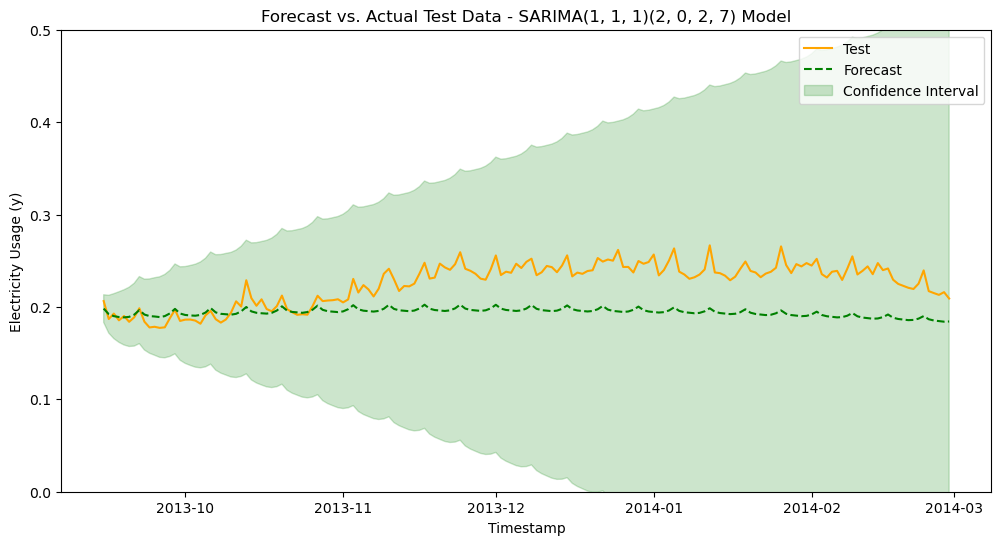

In [95]:
#just to extract log-likelihood that auto_arima package does not have
print("Fitting the SARIMA(1, 1, 1)(2, 0, 2, 7) model on the entire training dataset...")
model = SARIMAX(
    train_series,
    order=(1, 1, 1),
    seasonal_order=(2, 0, 2, 7), 
    trend='c', 
    enforce_stationarity=False,
    enforce_invertibility=False
)
fitted_model = model.fit(disp=False)

print("Forecasting...")
forecast = fitted_model.get_forecast(steps=len(test_series))
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

forecast_values.index = test_series.index
conf_int.index = test_series.index

mape = mean_absolute_percentage_error(test_series, forecast_values)
rmse = np.sqrt(mean_squared_error(test_series, forecast_values))
log_likelihood = fitted_model.llf
aic = fitted_model.aic

print(f"Evaluation Metrics:")
print(f"  MAPE: {mape:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  Log-Likelihood: {log_likelihood:.4f}")
print(f"  AIC: {aic:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_series.index, test_series, label='Test', color='orange')
plt.plot(forecast_values.index, forecast_values, label='Forecast', linestyle='--', color='green')
plt.fill_between(
    conf_int.index,
    conf_int.iloc[:, 0], 
    conf_int.iloc[:, 1],  
    color='green',
    alpha=0.2,
    label='Confidence Interval'
)
plt.title("Forecast vs. Actual Test Data - SARIMA(1, 1, 1)(2, 0, 2, 7) Model")
plt.xlabel("Timestamp")
plt.ylabel("Electricity Usage (y)")
plt.ylim(0, 0.5)  
plt.legend()
plt.show()

SARIMA(1,1,1)(2,0,2,7) captures the weekly trends in the forecast that the previous models did not. The model fit on train data (log-likelihood and AIC) are also better along with the forecast performance (MAPE and RMSE) on test data.

We tried doing the same thing for the annual seasonality instead but the kernel crashed several times and in the interest of time moved on to the next model to try to capture that seasonality in a different way.

**SARIMAX**
 - Add yearly variation into SARIMA models via Fourier Transform
 - Add yearly variation into SARIMA models using weather variables

Adding Fourier terms for yearly trends...
Fitting the SARIMA(1, 1, 1)(2, 0, 2, 7) model with Fourier terms for yearly trends...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:545: UserWarning:Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.


Forecasting...
Evaluation Metrics:
  MAPE: 0.2127
  RMSE: 0.0572
  Log-Likelihood: 2248.4252
  AIC: -4478.8505


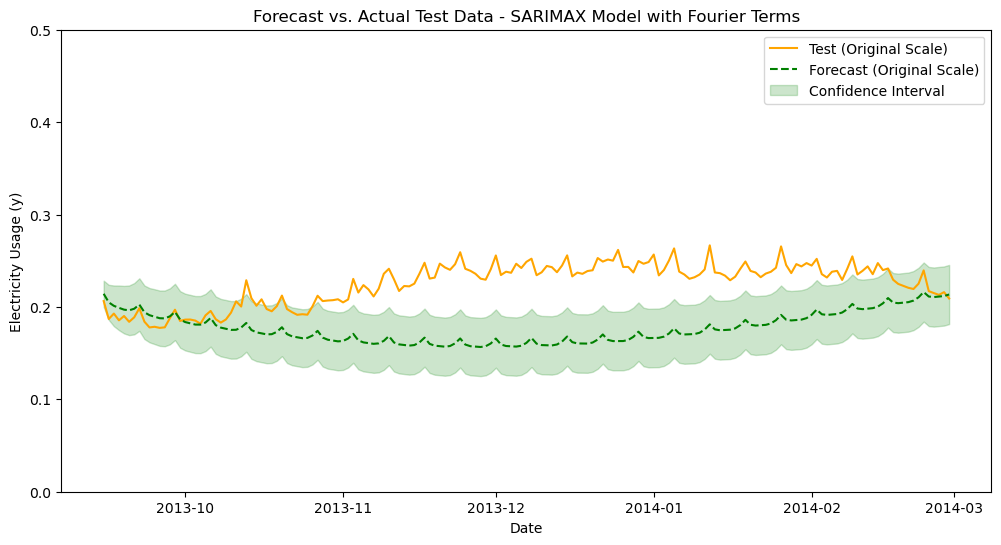

In [64]:
print("Adding Fourier terms for yearly trends...")
fourier_yearly = Fourier(period=365.25, order=1)
fourier_terms_train = fourier_yearly.in_sample(index=train_series.index)

print("Fitting the SARIMA(1, 1, 1)(2, 0, 2, 7) model with Fourier terms for yearly trends...")
model = SARIMAX(
    endog=train_series,
    exog=fourier_terms_train,
    order=(1, 1, 1), 
    seasonal_order=(2, 0, 2, 7),  
    enforce_stationarity=False,
    enforce_invertibility=False,
)

results = model.fit(disp=False)

print("Forecasting...")
future_fourier_terms = fourier_yearly.out_of_sample(steps=len(test_series), index=test_series.index)
forecast_values = results.get_forecast(steps=len(test_series), exog=future_fourier_terms).predicted_mean
conf_int = results.get_forecast(steps=len(test_series), exog=future_fourier_terms).conf_int()

mape = mean_absolute_percentage_error(test_series, forecast_values)
rmse = np.sqrt(mean_squared_error(test_series, forecast_values))
aic = results.aic
log_likelihood = results.llf

print(f"Evaluation Metrics:")
print(f"  MAPE: {mape:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  Log-Likelihood: {log_likelihood:.4f}")
print(f"  AIC: {aic:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_series.index, test_series, label='Test (Original Scale)', color='orange')
plt.plot(test_series.index, forecast_values, label='Forecast (Original Scale)', linestyle='--', color='green')
plt.fill_between(
    test_series.index, 
    conf_int.iloc[:, 0], 
    conf_int.iloc[:, 1], 
    color='green', alpha=0.2, label='Confidence Interval'
)
plt.title("Forecast vs. Actual Test Data - SARIMAX Model with Fourier Terms")
plt.xlabel("Date")
plt.ylabel("Electricity Usage (y)")
plt.ylim(0,0.5)
plt.legend()
plt.show()

This above method fared poorly... 

So we tried using weather data to model annual seasonality since weather is a causal factor for electricity demand and exhibits strong annual patterns.

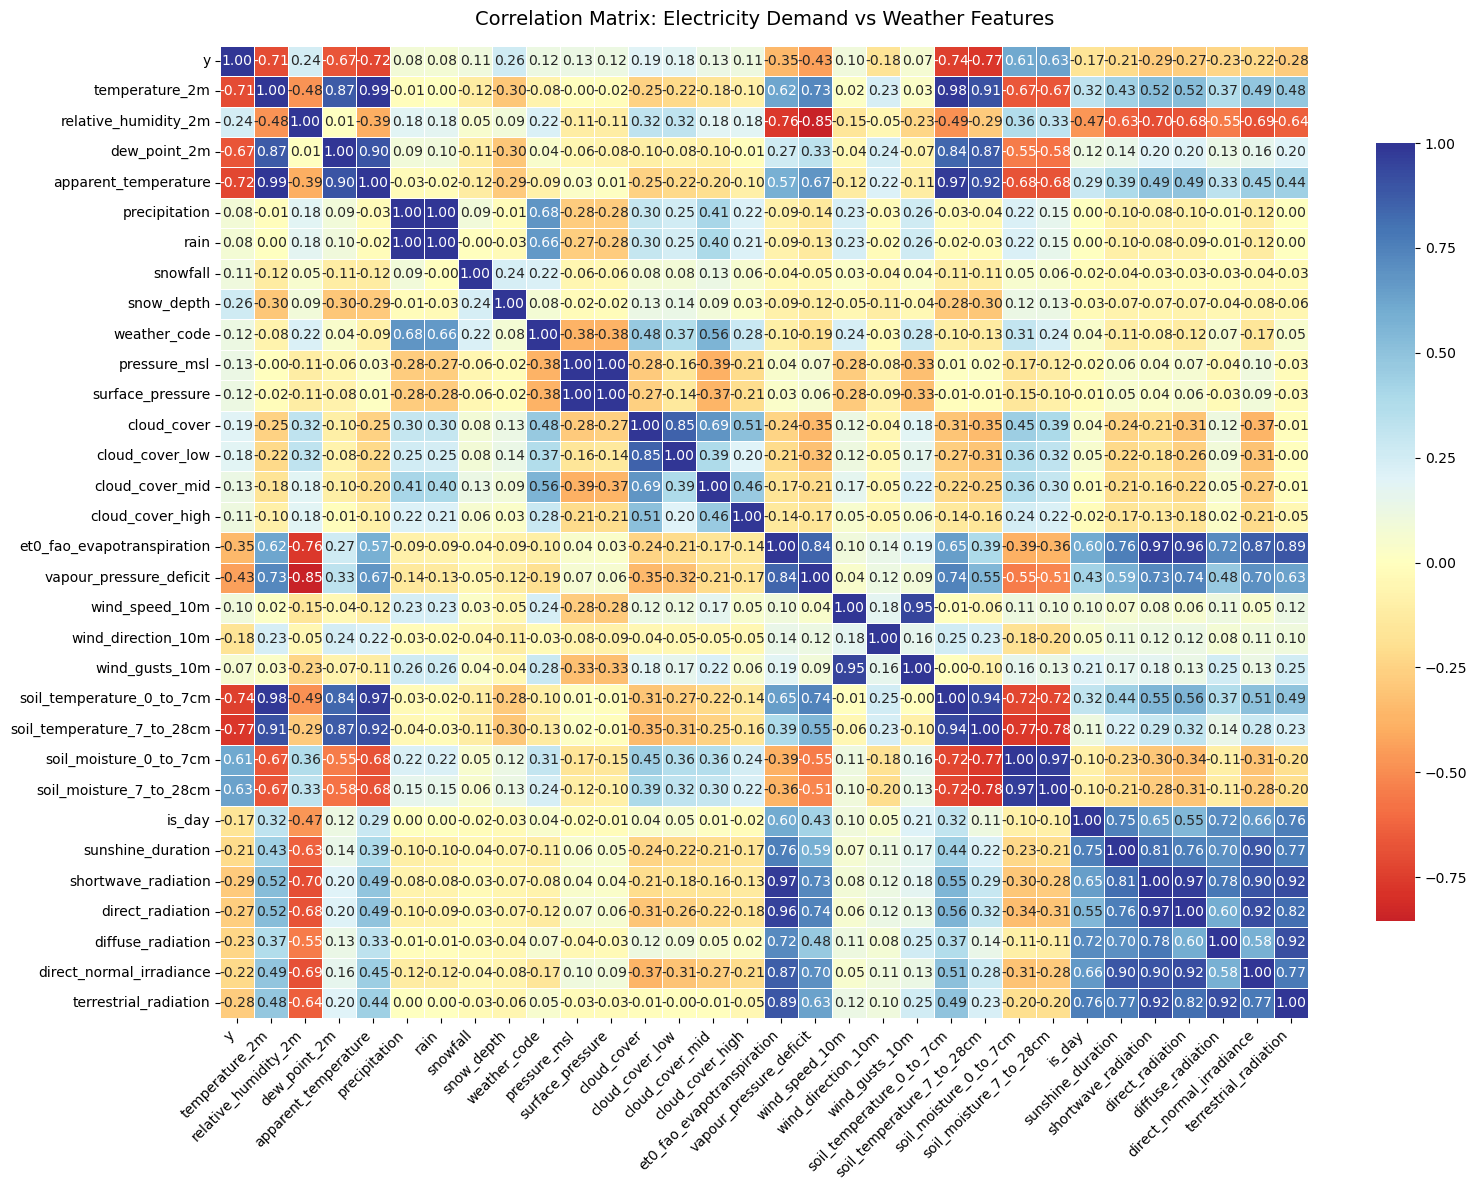

soil_temperature_7_to_28cm    0.773650
soil_temperature_0_to_7cm     0.741306
apparent_temperature          0.720540
temperature_2m                0.707787
dew_point_2m                  0.673271
Name: y, dtype: float64

In [ ]:
weather['date'] = weather['timestamp'].dt.date

merged_data = pd.merge(train_data_daily, weather, on='date', how='inner')

correlation_matrix = merged_data.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="RdYlBu", center=0, cbar_kws={"shrink": 0.8}, linewidths=0.5)
plt.xticks(rotation=45, fontsize=10, ha="right")
plt.yticks(fontsize=10)
plt.title("Correlation Matrix: Electricity Demand vs Weather Features", fontsize=14, pad=15)

plt.tight_layout()
plt.show()

correlation_with_y = correlation_matrix['y'].abs().sort_values(ascending=False)

top_5_features = correlation_with_y.iloc[1:6]  
top_5_features

Fitting SARIMA(1, 1, 1)(2, 0, 2, 7) with weather data...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Forecasting...
Evaluation Metrics:
  MAPE: 0.0487
  RMSE: 0.0134
  Log-Likelihood: 2311.2820
  AIC: -4604.5640


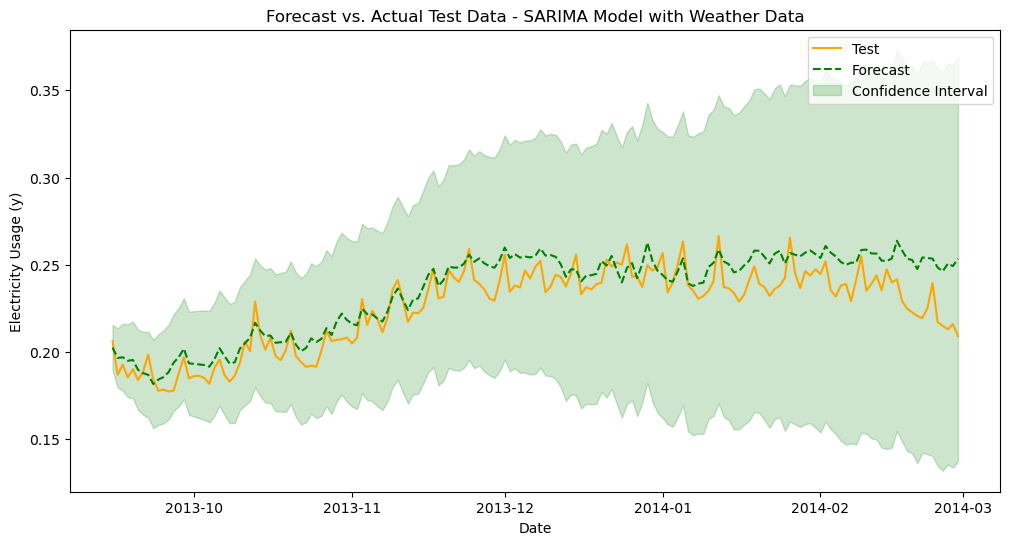

In [ ]:
weather['date'] = pd.to_datetime(weather['timestamp']).dt.date  
weather = weather.set_index('date')  

weather = weather[['temperature_2m','soil_temperature_7_to_28cm']]  

weather.index = pd.to_datetime(weather.index)  
weather_data = weather.resample('D').mean().fillna(method='ffill') 

weather_train = weather_data.loc[train_data_daily['date'].min():train_data_daily['date'].max()]
weather_test = weather_data.loc[test_data_daily['date'].min():test_data_daily['date'].max()]

scaler = StandardScaler()
weather_train_scaled = scaler.fit_transform(weather_train)
weather_test_scaled = scaler.transform(weather_test)

train_endog = train_data_daily.set_index('date')['y']
test_endog = test_data_daily.set_index('date')['y']

print("Fitting SARIMA(1, 1, 1)(2, 0, 2, 7) with weather data...")
model = SARIMAX(
    endog=train_endog,
    exog=weather_train_scaled,
    order=(1, 1, 1),
    seasonal_order=(2, 0, 2, 7),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results = model.fit(disp=False)

print("Forecasting...")
forecast_values = results.get_forecast(steps=len(test_endog), exog=weather_test_scaled).predicted_mean
conf_int = results.get_forecast(steps=len(test_endog), exog=weather_test_scaled).conf_int()

mape = mean_absolute_percentage_error(test_endog, forecast_values)
rmse = np.sqrt(mean_squared_error(test_endog, forecast_values))
aic = results.aic
log_likelihood = results.llf


print(f"Evaluation Metrics:")
print(f"  MAPE: {mape:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  Log-Likelihood: {log_likelihood:.4f}")
print(f"  AIC: {aic:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_endog.index, test_endog, label='Test', color='orange')
plt.plot(test_endog.index, forecast_values, label='Forecast', linestyle='--', color='green')
plt.fill_between(test_endog.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2, label='Confidence Interval')
plt.title("Forecast vs. Actual Test Data - SARIMA Model with Weather Data")
plt.xlabel("Date")
plt.ylabel("Electricity Usage (y)")
plt.legend()
plt.show()

SARIMA(1, 1, 1)(2, 0, 2, 7) with weather data showed very good results, capturing both weekly and annual seasonality and also the best model fit and forecast performance.

Next, we tried playing around with the following factors to improve this model:
- Selection of weather variables
- AR order
- Uncertainty bands (white noise variance)


In [ ]:
weather = pd.read_parquet(weather_file)
weather['date'] = pd.to_datetime(weather['timestamp']).dt.date  
weather = weather.set_index('date')  

save_weather = weather.copy()

filters = {
    "a": ['soil_temperature_7_to_28cm'],
    "b": ['soil_temperature_7_to_28cm', 'soil_temperature_0_to_7cm'],
    "c": ['soil_temperature_7_to_28cm', 'soil_temperature_0_to_7cm', 'apparent_temperature'],
    "d": ['soil_temperature_7_to_28cm', 'soil_temperature_0_to_7cm', 'apparent_temperature', 'temperature_2m'],
    "e": ['soil_temperature_7_to_28cm', 'soil_temperature_0_to_7cm', 'apparent_temperature', 'temperature_2m', 'dew_point_2m']
}

results_summary = []

for name, selected_features in filters.items():
    print(f"Processing filter: {name} with features: {selected_features}")
    
    weather_filtered = save_weather[selected_features]
    weather_filtered.index = pd.to_datetime(weather_filtered.index) 

    weather_data = weather_filtered.resample('D').mean().fillna(method='ffill')
    weather_train = weather_data.loc[train_data_daily['date'].min():train_data_daily['date'].max()]
    weather_test = weather_data.loc[test_data_daily['date'].min():test_data_daily['date'].max()]

    scaler = StandardScaler()
    weather_train_scaled = scaler.fit_transform(weather_train)
    weather_test_scaled = scaler.transform(weather_test)

    print(f"Fitting SARIMA(1, 1, 1)(2, 0, 2, 7) with filter {name}...")
    try:
        model = SARIMAX(
            endog=train_endog,
            exog=weather_train_scaled,
            order=(1, 1, 1),
            seasonal_order=(2, 0, 2, 7),
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        results = model.fit(disp=False)

        forecast = results.get_forecast(steps=len(test_endog), exog=weather_test_scaled)
        forecast_values = forecast.predicted_mean
        conf_int = forecast.conf_int()

        forecast_values.index = test_endog.index
        conf_int.index = test_endog.index

        mape = mean_absolute_percentage_error(test_endog, forecast_values)
        rmse = np.sqrt(mean_squared_error(test_endog, forecast_values))
        aic = results.aic
        log_likelihood = results.llf

        results_summary.append({
            "features": selected_features,
            "MAPE": mape,
            "RMSE": rmse,
            "Log-Likelihood": log_likelihood,
            "AIC": aic
        })

    except Exception as e:
        print(f"Error fitting model for filter {name}: {e}")
        continue

results_df = pd.DataFrame(results_summary)
print("Summary of Results:")
display(results_df)

Processing filter: a with features: ['soil_temperature_7_to_28cm']
Fitting SARIMA(1, 1, 1)(2, 0, 2, 7) with filter a...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Processing filter: b with features: ['soil_temperature_7_to_28cm', 'soil_temperature_0_to_7cm']
Fitting SARIMA(1, 1, 1)(2, 0, 2, 7) with filter b...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Processing filter: c with features: ['soil_temperature_7_to_28cm', 'soil_temperature_0_to_7cm', 'apparent_temperature']
Fitting SARIMA(1, 1, 1)(2, 0, 2, 7) with filter c...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Processing filter: d with features: ['soil_temperature_7_to_28cm', 'soil_temperature_0_to_7cm', 'apparent_temperature', 'temperature_2m']
Fitting SARIMA(1, 1, 1)(2, 0, 2, 7) with filter d...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Processing filter: e with features: ['soil_temperature_7_to_28cm', 'soil_temperature_0_to_7cm', 'apparent_temperature', 'temperature_2m', 'dew_point_2m']
Fitting SARIMA(1, 1, 1)(2, 0, 2, 7) with filter e...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Summary of Results:


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


,features,MAPE,RMSE,Log-Likelihood,AIC
0,[soil_temperature_7_to_28cm],0.040504,0.011047,2306.071715,-4596.143430
1,"[soil_temperature_7_to_28cm, soil_temperature_...",0.038447,0.010692,2322.347470,-4626.694939
2,"[soil_temperature_7_to_28cm, soil_temperature_...",0.037036,0.010346,2322.479565,-4624.959130
3,"[soil_temperature_7_to_28cm, soil_temperature_...",0.035625,0.009810,2329.854837,-4637.709674
4,"[soil_temperature_7_to_28cm, soil_temperature_...",0.075620,0.019461,2343.013968,-4662.027935


Processing and plotting for filter: d with features: ['soil_temperature_7_to_28cm', 'soil_temperature_0_to_7cm', 'apparent_temperature', 'temperature_2m']
Fitting SARIMA(1, 1, 1)(2, 0, 2, 7) with filter d...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluation Metrics for filter d:
  MAPE: 0.0356
  RMSE: 0.0098
  Log-Likelihood: 2329.8548
  AIC: -4637.7097


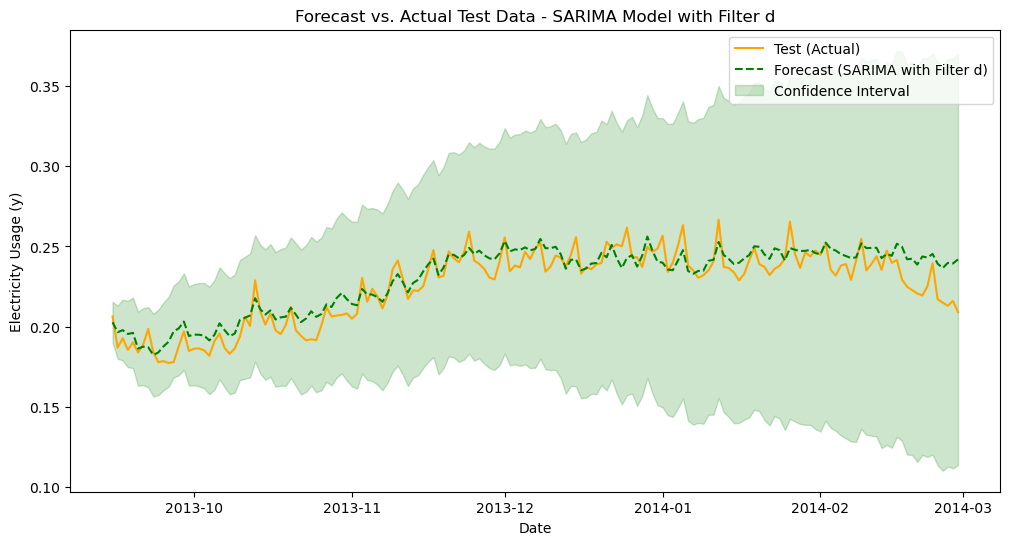

In [108]:
selected_features = ['soil_temperature_7_to_28cm', 'soil_temperature_0_to_7cm', 'apparent_temperature', 'temperature_2m']

print(f"Processing and plotting for filter: d with features: {selected_features}")

weather_filtered = save_weather[selected_features]
weather_filtered.index = pd.to_datetime(weather_filtered.index)  

weather_data = weather_filtered.resample('D').mean().fillna(method='ffill')
weather_train = weather_data.loc[train_data_daily['date'].min():train_data_daily['date'].max()]
weather_test = weather_data.loc[test_data_daily['date'].min():test_data_daily['date'].max()]

scaler = StandardScaler()
weather_train_scaled = scaler.fit_transform(weather_train)
weather_test_scaled = scaler.transform(weather_test)

print(f"Fitting SARIMA(1, 1, 1)(2, 0, 2, 7) with filter d...")
model = SARIMAX(
    endog=train_endog,
    exog=weather_train_scaled,
    order=(1, 1, 1),
    seasonal_order=(2, 0, 2, 7),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results = model.fit(disp=False)

forecast = results.get_forecast(steps=len(test_endog), exog=weather_test_scaled)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

forecast_values.index = test_endog.index
conf_int.index = test_endog.index

mape = mean_absolute_percentage_error(test_endog, forecast_values)
rmse = np.sqrt(mean_squared_error(test_endog, forecast_values))
aic = results.aic
log_likelihood = results.llf

print(f"Evaluation Metrics for filter d:")
print(f"  MAPE: {mape:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  Log-Likelihood: {log_likelihood:.4f}")
print(f"  AIC: {aic:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_endog.index, test_endog, label='Test (Actual)', color='orange')
plt.plot(test_endog.index, forecast_values, label='Forecast (SARIMA with Filter d)', linestyle='--', color='green')
plt.fill_between(
    test_endog.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color='green',
    alpha=0.2,
    label='Confidence Interval'
)
plt.title("Forecast vs. Actual Test Data - SARIMA Model with Filter d")
plt.xlabel("Date")
plt.ylabel("Electricity Usage (y)")
plt.legend()
plt.show()


To identify the best set of weather variables for modeling electricity demand, we evaluated multiple feature combinations by fitting a SARIMA model with each set of variables as exogenous inputs. Each model was compared using forecast performance on test data. The combination of ['soil_temperature_7_to_28cm', 'soil_temperature_0_to_7cm', 'apparent_temperature', 'temperature_2m'] did best with MAPE of ~3.56% with the above plot.

In [115]:
from itertools import product

p_values = range(0, 4)  
q_values = range(0, 4)  
P_values = range(0, 3)  
Q_values = range(0, 3)  
D_values = [0, 1]       
s_values = [7]         

parameter_grid = list(product(p_values, q_values, P_values, Q_values, D_values, s_values))

best_model = None
best_mape = float('inf')  
best_params = None

results_summary = []

for (p, q, P, Q, D, s) in parameter_grid:
    print(f"Evaluating SARIMA({p}, 1, {q})({P}, {D}, {Q}, {s})...")
    try:
        model = SARIMAX(
            endog=train_endog,
            exog=weather_train_scaled,  
            order=(p, 1, q),
            seasonal_order=(P, D, Q, s),  
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        results = model.fit(disp=False)

        forecast = results.get_forecast(steps=len(test_endog), exog=weather_test_scaled)
        forecast_values = forecast.predicted_mean
        forecast_values.index = test_endog.index

        mape = mean_absolute_percentage_error(test_endog, forecast_values)
        rmse = np.sqrt(mean_squared_error(test_endog, forecast_values))
        aic = results.aic

        results_summary.append({
            "AR": p,
            "MA": q,
            "Seasonal AR": P,
            "Seasonal MA": Q,
            "Seasonal D": D,
            "Seasonal Period": s,
            "MAPE": mape,
            "RMSE": rmse,
            "AIC": aic
        })

        if mape < best_mape:
            best_mape = mape
            best_model = results
            best_params = (p, q, P, Q, D, s)

    except Exception as e:
        print(f"Failed to fit SARIMA({p}, 1, {q})({P}, {D}, {Q}, {s}): {e}")
        continue

if not results_summary:
    print("No valid models were found. Please check your data or parameter grid.")
else:
    
    results_df = pd.DataFrame(results_summary)
    print("Summary of Results:")
    display(results_df)

    print(f"Best SARIMA Model: SARIMA({best_params[0]}, 1, {best_params[1]})({best_params[2]}, {best_params[4]}, {best_params[3]}, {best_params[5]}) with MAPE: {best_mape:.4f}")


Evaluating SARIMA(0, 1, 0)(0, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 0)(0, 1, 0, 7)...
Evaluating SARIMA(0, 1, 0)(0, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 0)(0, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 0)(0, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 0)(0, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(0, 1, 0)(1, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 0)(1, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 0)(1, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 0)(1, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 0)(1, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 0)(1, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(0, 1, 0)(2, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 0)(2, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 0)(2, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 0)(2, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(0, 1, 0)(2, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 0)(2, 1, 2, 7)...
Evaluating SARIMA(0, 1, 1)(0, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 1)(0, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 1)(0, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 1)(0, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 1)(0, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 1)(0, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(0, 1, 1)(1, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 1)(1, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 1)(1, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 1)(1, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 1)(1, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 1)(1, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(0, 1, 1)(2, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 1)(2, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 1)(2, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 1)(2, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(0, 1, 1)(2, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 1)(2, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(0, 1, 2)(0, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 2)(0, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 2)(0, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 2)(0, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 2)(0, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 2)(0, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(0, 1, 2)(1, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 2)(1, 1, 0, 7)...
Evaluating SARIMA(0, 1, 2)(1, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 2)(1, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 2)(1, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 2)(1, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(0, 1, 2)(2, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 2)(2, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(0, 1, 2)(2, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 2)(2, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(0, 1, 2)(2, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 2)(2, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(0, 1, 3)(0, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 3)(0, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 3)(0, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 3)(0, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 3)(0, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 3)(0, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(0, 1, 3)(1, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 3)(1, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 3)(1, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 3)(1, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 3)(1, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 3)(1, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(0, 1, 3)(2, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 3)(2, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(0, 1, 3)(2, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 3)(2, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(0, 1, 3)(2, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(0, 1, 3)(2, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(1, 1, 0)(0, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 0)(0, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 0)(0, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 0)(0, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 0)(0, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 0)(0, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(1, 1, 0)(1, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 0)(1, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 0)(1, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 0)(1, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 0)(1, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 0)(1, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(1, 1, 0)(2, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 0)(2, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 0)(2, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 0)(2, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(1, 1, 0)(2, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 0)(2, 1, 2, 7)...
Evaluating SARIMA(1, 1, 1)(0, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 1)(0, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 1)(0, 0, 1, 7)...
Evaluating SARIMA(1, 1, 1)(0, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 1)(0, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 1)(0, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(1, 1, 1)(1, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 1)(1, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 1)(1, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 1)(1, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 1)(1, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 1)(1, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(1, 1, 1)(2, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 1)(2, 1, 0, 7)...
Evaluating SARIMA(1, 1, 1)(2, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 1)(2, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(1, 1, 1)(2, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 1)(2, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(1, 1, 2)(0, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 2)(0, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 2)(0, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(1, 1, 2)(0, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(1, 1, 2)(0, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 2)(0, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(1, 1, 2)(1, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 2)(1, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 2)(1, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 2)(1, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 2)(1, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(1, 1, 2)(1, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(1, 1, 2)(2, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 2)(2, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(1, 1, 2)(2, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 2)(2, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(1, 1, 2)(2, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(1, 1, 2)(2, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(1, 1, 3)(0, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 3)(0, 1, 0, 7)...
Evaluating SARIMA(1, 1, 3)(0, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(1, 1, 3)(0, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 3)(0, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 3)(0, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(1, 1, 3)(1, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 3)(1, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 3)(1, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 3)(1, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 3)(1, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 3)(1, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(1, 1, 3)(2, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 3)(2, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(1, 1, 3)(2, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 3)(2, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(1, 1, 3)(2, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(1, 1, 3)(2, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 0)(0, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 0)(0, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 0)(0, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 0)(0, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 0)(0, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 0)(0, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 0)(1, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 0)(1, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 0)(1, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 0)(1, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 0)(1, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 0)(1, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 0)(2, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 0)(2, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 0)(2, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 0)(2, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 0)(2, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 0)(2, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 1)(0, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 1)(0, 1, 0, 7)...
Evaluating SARIMA(2, 1, 1)(0, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 1)(0, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 1)(0, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 1)(0, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 1)(1, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 1)(1, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 1)(1, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 1)(1, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 1)(1, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 1)(1, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 1)(2, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 1)(2, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 1)(2, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 1)(2, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 1)(2, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 1)(2, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 2)(0, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 2)(0, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 2)(0, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 2)(0, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 2)(0, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 2)(0, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 2)(1, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 2)(1, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 2)(1, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 2)(1, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 2)(1, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 2)(1, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 2)(2, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 2)(2, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 2)(2, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 2)(2, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 2)(2, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 2)(2, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 3)(0, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 3)(0, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 3)(0, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 3)(0, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 3)(0, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 3)(0, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 3)(1, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 3)(1, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 3)(1, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 3)(1, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 3)(1, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 3)(1, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 3)(2, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 3)(2, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 3)(2, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(2, 1, 3)(2, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 3)(2, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(2, 1, 3)(2, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(3, 1, 0)(0, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 0)(0, 1, 0, 7)...
Evaluating SARIMA(3, 1, 0)(0, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 0)(0, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 0)(0, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 0)(0, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(3, 1, 0)(1, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 0)(1, 1, 0, 7)...
Evaluating SARIMA(3, 1, 0)(1, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 0)(1, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 0)(1, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 0)(1, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(3, 1, 0)(2, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 0)(2, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(3, 1, 0)(2, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 0)(2, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(3, 1, 0)(2, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 0)(2, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(3, 1, 1)(0, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 1)(0, 1, 0, 7)...
Evaluating SARIMA(3, 1, 1)(0, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 1)(0, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 1)(0, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 1)(0, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(3, 1, 1)(1, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 1)(1, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 1)(1, 0, 1, 7)...
Evaluating SARIMA(3, 1, 1)(1, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 1)(1, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 1)(1, 1, 2, 7)...
Evaluating SARIMA(3, 1, 1)(2, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 1)(2, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(3, 1, 1)(2, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 1)(2, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(3, 1, 1)(2, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(3, 1, 1)(2, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(3, 1, 2)(0, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 2)(0, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 2)(0, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 2)(0, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 2)(0, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 2)(0, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(3, 1, 2)(1, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 2)(1, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 2)(1, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 2)(1, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 2)(1, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 2)(1, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(3, 1, 2)(2, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 2)(2, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(3, 1, 2)(2, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 2)(2, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(3, 1, 2)(2, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(3, 1, 2)(2, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(3, 1, 3)(0, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 3)(0, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 3)(0, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 3)(0, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 3)(0, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 3)(0, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(3, 1, 3)(1, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 3)(1, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 3)(1, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 3)(1, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 3)(1, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 3)(1, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(3, 1, 3)(2, 0, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 3)(2, 1, 0, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(3, 1, 3)(2, 0, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 3)(2, 1, 1, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluating SARIMA(3, 1, 3)(2, 0, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


Evaluating SARIMA(3, 1, 3)(2, 1, 2, 7)...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Summary of Results:


,AR,MA,Seasonal AR,Seasonal MA,Seasonal D,Seasonal Period,MAPE,RMSE,AIC
0,0,0,0,0,0,7,4.805052e-02,1.227643e-02,-4355.422020
1,0,0,0,0,1,7,9.351087e-01,2.483729e-01,-4274.441886
2,0,0,0,1,0,7,6.829966e-02,1.666687e-02,-4410.715837
3,0,0,0,1,1,7,4.869866e-02,1.275131e-02,-4623.339755
4,0,0,0,2,0,7,7.368914e-02,1.788712e-02,-4421.996185
...,...,...,...,...,...,...,...,...,...
283,3,3,2,0,1,7,2.552597e+18,2.896776e+18,-3432.907900
284,3,3,2,1,0,7,8.084481e-02,2.007429e-02,-4566.449123
285,3,3,2,1,1,7,1.029693e+19,1.098914e+19,-3559.144523
286,3,3,2,2,0,7,5.325732e-02,1.383808e-02,-4599.856564


Best SARIMA Model: SARIMA(1, 1, 2)(0, 1, 2, 7) with MAPE: 0.0290


In [117]:
display(results_df)
print(f"Best SARIMA Model: SARIMA({best_params[0]}, 1, {best_params[1]})({best_params[2]}, {best_params[4]}, {best_params[3]}, {best_params[5]}) with MAPE: {best_mape:.4f}")

,AR,MA,Seasonal AR,Seasonal MA,Seasonal D,Seasonal Period,MAPE,RMSE,AIC
0,0,0,0,0,0,7,4.805052e-02,1.227643e-02,-4355.422020
1,0,0,0,0,1,7,9.351087e-01,2.483729e-01,-4274.441886
2,0,0,0,1,0,7,6.829966e-02,1.666687e-02,-4410.715837
3,0,0,0,1,1,7,4.869866e-02,1.275131e-02,-4623.339755
4,0,0,0,2,0,7,7.368914e-02,1.788712e-02,-4421.996185
...,...,...,...,...,...,...,...,...,...
283,3,3,2,0,1,7,2.552597e+18,2.896776e+18,-3432.907900
284,3,3,2,1,0,7,8.084481e-02,2.007429e-02,-4566.449123
285,3,3,2,1,1,7,1.029693e+19,1.098914e+19,-3559.144523
286,3,3,2,2,0,7,5.325732e-02,1.383808e-02,-4599.856564


Best SARIMA Model: SARIMA(1, 1, 2)(0, 1, 2, 7) with MAPE: 0.0290


Fitting SARIMA(1, 1, 2)(0, 1, 2, 7) with filter d...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluation Metrics for filter d:
  MAPE: 0.0290
  RMSE: 0.0083
  Log-Likelihood: 2304.2430
  AIC: -4588.4860


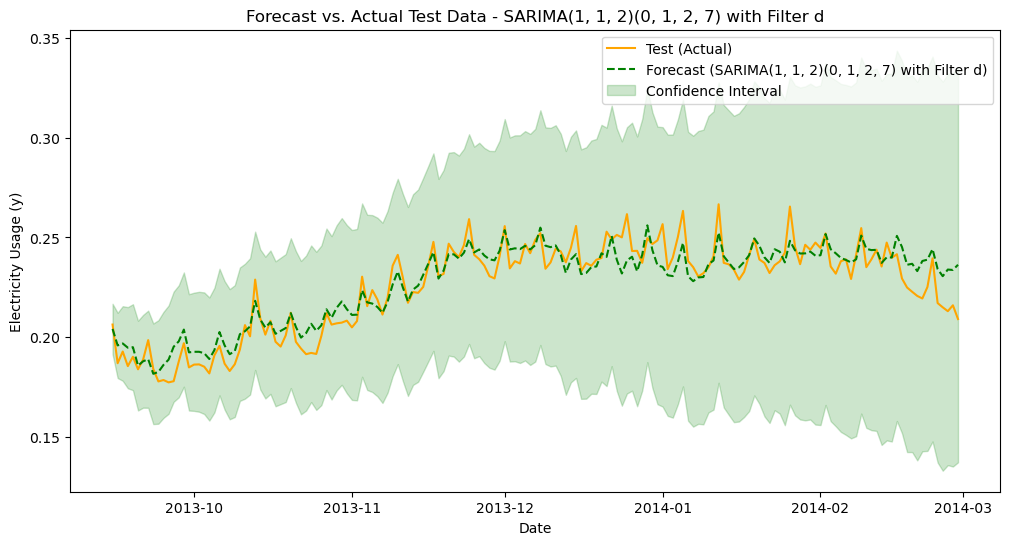

In [118]:
print(f"Fitting SARIMA(1, 1, 2)(0, 1, 2, 7) with filter d...")
model = SARIMAX(
    endog=train_endog,
    exog=weather_train_scaled,
    order=(1, 1, 2),
    seasonal_order=(0, 1, 2, 7),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results = model.fit(disp=False)

forecast = results.get_forecast(steps=len(test_endog), exog=weather_test_scaled)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

forecast_values.index = test_endog.index
conf_int.index = test_endog.index

mape = mean_absolute_percentage_error(test_endog, forecast_values)
rmse = np.sqrt(mean_squared_error(test_endog, forecast_values))
aic = results.aic
log_likelihood = results.llf

print(f"Evaluation Metrics for filter d:")
print(f"  MAPE: {mape:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  Log-Likelihood: {log_likelihood:.4f}")
print(f"  AIC: {aic:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_endog.index, test_endog, label='Test (Actual)', color='orange')
plt.plot(test_endog.index, forecast_values, label='Forecast (SARIMA(1, 1, 2)(0, 1, 2, 7) with Filter d)', linestyle='--', color='green')
plt.fill_between(
    test_endog.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color='green',
    alpha=0.2,
    label='Confidence Interval'
)
plt.title("Forecast vs. Actual Test Data - SARIMA(1, 1, 2)(0, 1, 2, 7) with Filter d")
plt.xlabel("Date")
plt.ylabel("Electricity Usage (y)")
plt.legend()
plt.show()


Similarlly, to identify the best set of variables (p, q, P, D, Q) for SARIMAX, we evaluated multiple parameter combinations while using the best set of weather variables we had just found. Each model was compared using forecast performance on test data. The combination of SARIMA(1, 1, 2)(0, 1, 2, 7) did best with MAPE of ~2.90% with the above plot.

Fitting SARIMA(1, 1, 2)(0, 1, 2, 7) with filter d...


 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


Evaluation Metrics for filter d:
  MAPE: 0.0290
  RMSE: 0.0083
  Log-Likelihood: 2304.2430
  AIC: -4588.4860


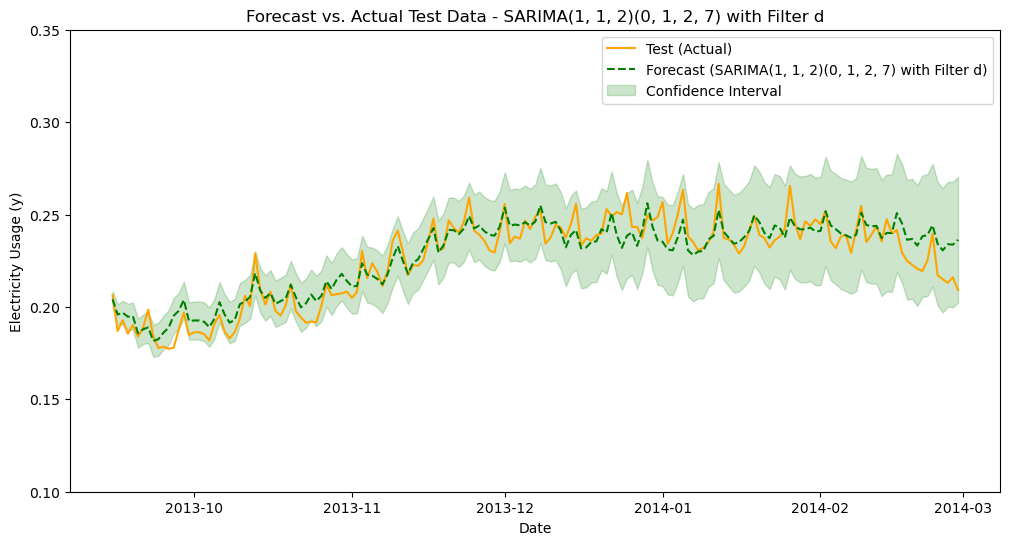

In [146]:
print(f"Fitting SARIMA(1, 1, 2)(0, 1, 2, 7) with filter d...")
model = SARIMAX(
    endog=train_endog,
    exog=weather_train_scaled,
    order=(1, 1, 2),
    seasonal_order=(0, 1, 2, 7),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results = model.fit(disp=False)

forecast = results.get_forecast(steps=len(test_endog), exog=weather_test_scaled)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.5)

forecast_values.index = test_endog.index
conf_int.index = test_endog.index

mape = mean_absolute_percentage_error(test_endog, forecast_values)
rmse = np.sqrt(mean_squared_error(test_endog, forecast_values))
aic = results.aic
log_likelihood = results.llf

print(f"Evaluation Metrics for filter d:")
print(f"  MAPE: {mape:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  Log-Likelihood: {log_likelihood:.4f}")
print(f"  AIC: {aic:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_endog.index, test_endog, label='Test (Actual)', color='orange')
plt.plot(test_endog.index, forecast_values, label='Forecast (SARIMA(1, 1, 2)(0, 1, 2, 7) with Filter d)', linestyle='--', color='green')
plt.fill_between(
    test_endog.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color='green',
    alpha=0.2,
    label='Confidence Interval'
)
plt.title("Forecast vs. Actual Test Data - SARIMA(1, 1, 2)(0, 1, 2, 7) with Filter d")
plt.xlabel("Date")
plt.ylabel("Electricity Usage (y)")
plt.ylim(0.1,0.35)
plt.legend()
plt.show()


We narrowed the uncertainty bands by setting alpha = 0.5 (it was 0.05 prior). This reduced the likelihood of the true value being within the interval. It is more practical to work with a smaller range of potential outcomes because it allows better allocation of resources. And this is a tradeoff between precision and confidence.

What was surprising though was that we had a 50% confidence interval which would mean we should expect to see 50% of the test data to fall outside of the interval but that is not what we see here. This led us to check for model misspecifications by looking at the residuals as it should follow a white noise process of zero mean, constant variance and be normally distributed.

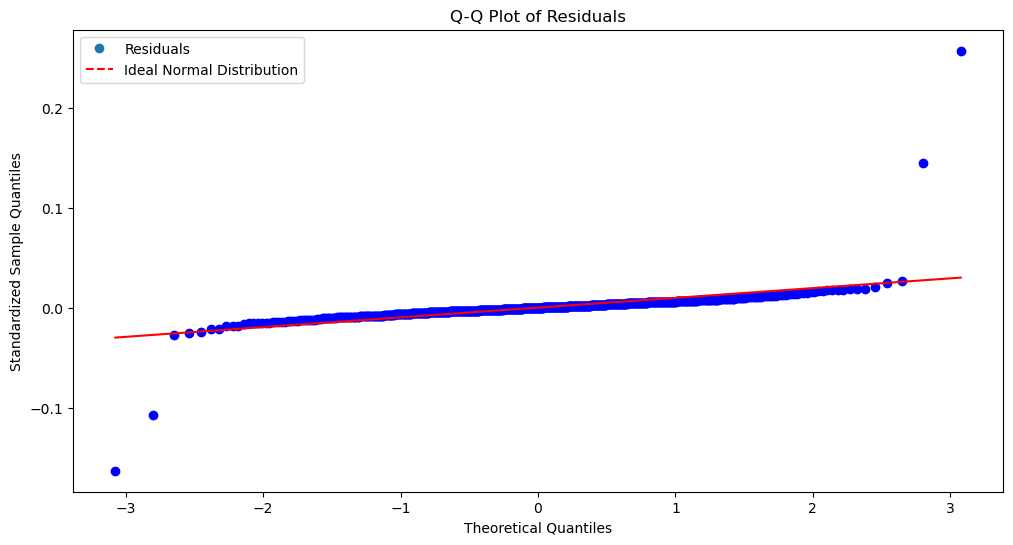

In [150]:
import scipy.stats as stats

residuals = results.resid

plt.figure(figsize=(12, 6))

stats.probplot(residuals, dist="norm", plot=plt)

plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Sample Quantiles")

plt.plot([], [], 'o', label="Residuals")  
plt.plot([], [], 'r--', label="Ideal Normal Distribution") 
plt.legend()

plt.title("Q-Q Plot of Residuals")

plt.show()


The Q-Q plot showed us that our model is valid, as the residuals adhere to the assumptions of normality. Next we checked for calibration error which measures the difference between predicted probabilities and the actual observed frequencies.

In [152]:
from scipy.stats import norm
import numpy as np

def calculate_calibration_error(test_actual, lower_bound, upper_bound, confidence_level=0.5):
    within_interval = (test_actual >= lower_bound) & (test_actual <= upper_bound)
    actual_coverage = within_interval.mean()
    expected_coverage = confidence_level
    calibration_error = abs(actual_coverage - expected_coverage)

    return {
        "actual_coverage": actual_coverage,
        "expected_coverage": expected_coverage,
        "calibration_error": calibration_error,
        "under_coverage": actual_coverage < expected_coverage,
        "over_coverage": actual_coverage > expected_coverage
    }

confidence_level = 0.5
calibration_metrics = calculate_calibration_error(
    test_actual=test_endog,
    lower_bound=conf_int.iloc[:, 0],
    upper_bound=conf_int.iloc[:, 1],
    confidence_level=confidence_level
)

print("Calibration Metrics:")
for key, value in calibration_metrics.items():
    print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")


Calibration Metrics:
  actual_coverage: 0.9521
  expected_coverage: 0.5000
  calibration_error: 0.4521
  under_coverage: False
  over_coverage: True


This shows that there is a miscalibration -over-coverage- where the proportion of the test data points whose actual values fall within the confidence intervals is greater than the expected values that fall within the confidence intervals. This could be the result of the training data having higher variability than the test data which resulted in the model producing predictions with higher standard deviation than necessary and would be something to further investigate.

**Gaussian Processes**
- Explore model fit on training data
- Evaluate how well the model performs on unseen data

Two Kernels: (1) RBF & weekly periodic kernel (2) RBF & weekly + annual periodic kernel

Log-Likelihood: 42.5614
AIC: -73.1227


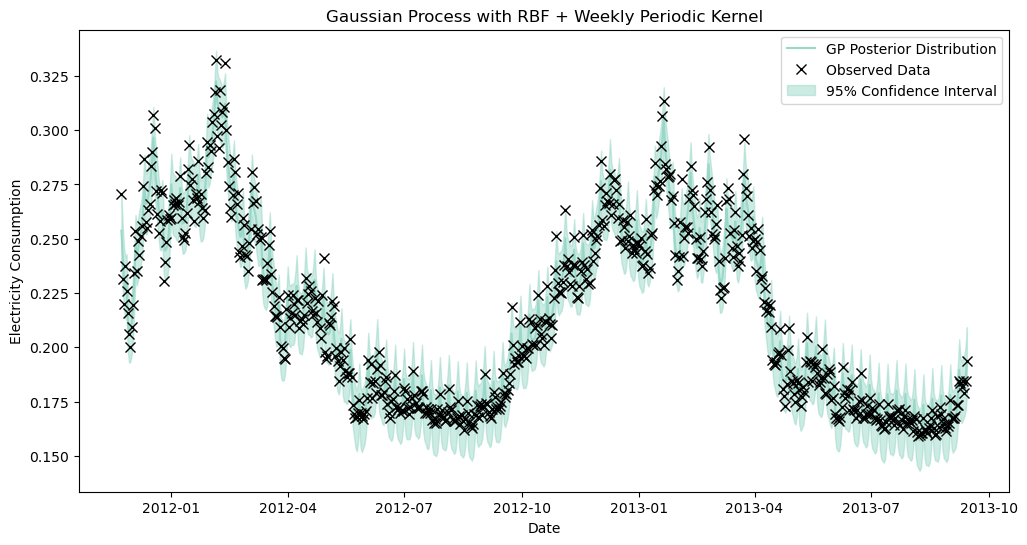

In [75]:
train_series.index = pd.to_datetime(train_series.index)
X = (train_series.index - train_series.index.min()).days.values.reshape(-1, 1)
y = np.array(train_series).reshape(-1, 1)

y_mean = y.mean()
y_std = y.std()
y_normalized = (y - y_mean) / y_std

k_rbf = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=50.0)
k_periodic = GPy.kern.StdPeriodic(input_dim=1, variance=0.7, lengthscale=20.0, period=7)
kernel = k_rbf + k_periodic

model = GPy.models.GPRegression(X, y_normalized, kernel)
model.optimize(messages=True, max_iters=300)

y_pred_mean, y_var = model.predict(X)
y_pred_mean = y_pred_mean * y_std + y_mean
y_pred_std = np.sqrt(y_var) * y_std

log_likelihood = model.log_likelihood()
num_parameters = len(model.param_array)  
aic = 2 * num_parameters - 2 * log_likelihood

print(f"Log-Likelihood: {log_likelihood:.4f}")
print(f"AIC: {aic:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(train_series.index, y_pred_mean, color='#99d8c9', label='GP Posterior Distribution')
plt.plot(train_series.index, y, 'x', color='k', label='Observed Data', markersize=7)
plt.fill_between(
    train_series.index,
    (y_pred_mean - 2 * y_pred_std).flatten(),
    (y_pred_mean + 2 * y_pred_std).flatten(),
    color='#99d8c9',
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
# plt.ylim(0, 0.5)
plt.title('Gaussian Process with RBF + Weekly Periodic Kernel')
plt.show()

Test Mean Squared Error (MSE): 0.0005
Test Mean Absolute Percentage Error (MAPE): 9.27%


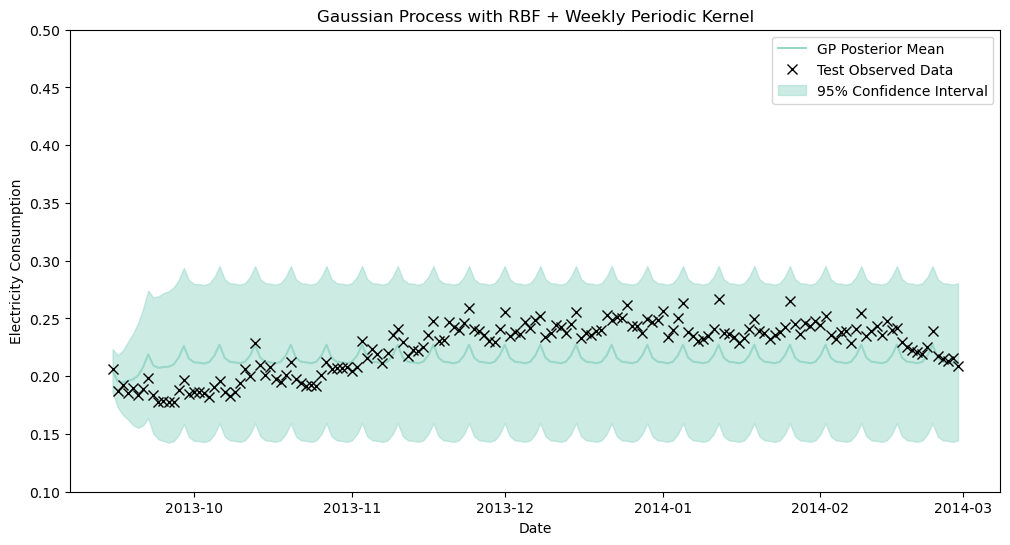

In [76]:
test_series = test_data_daily.set_index('date')['y']

test_series.index = pd.to_datetime(test_series.index)
X_test = (test_series.index - train_series.index.min()).days.values.reshape(-1, 1)
y_test = np.array(test_series).reshape(-1, 1)

y_pred_test, y_var_test = model.predict(X_test)
y_pred_test = y_pred_test * y_std + y_mean
y_std_test = np.sqrt(y_var_test) * y_std

mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print(f"Test Mean Squared Error (MSE): {mse_test:.4f}")
print(f"Test Mean Absolute Percentage Error (MAPE): {mape_test:.2%}")

plt.figure(figsize=(12, 6))
plt.plot(test_series.index, y_pred_test, color='#99d8c9', label='GP Posterior Mean')
plt.plot(test_series.index, y_test, 'x', color='k', label='Test Observed Data', markersize=7)
plt.fill_between(
    test_series.index,
    (y_pred_test - 2 * y_std_test).flatten(),
    (y_pred_test + 2 * y_std_test).flatten(),
    color='#99d8c9',
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.ylim(0.1, 0.5)
plt.title('Gaussian Process with RBF + Weekly Periodic Kernel')
plt.show()

 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/GPy/kern/src/standard_periodic.py:513: RuntimeWarning:divide by zero encountered in true_divide
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/GPy/kern/src/standard_periodic.py:513: RuntimeWarning:invalid value encountered in true_divide
 /Users/fionachow/opt/anaconda3/envs/py39/lib/python3.9/site-packages/GPy/kern/src/standard_periodic.py:526: RuntimeWarning:invalid value encountered in multiply


Log-Likelihood: 66.8414
AIC: -115.6828


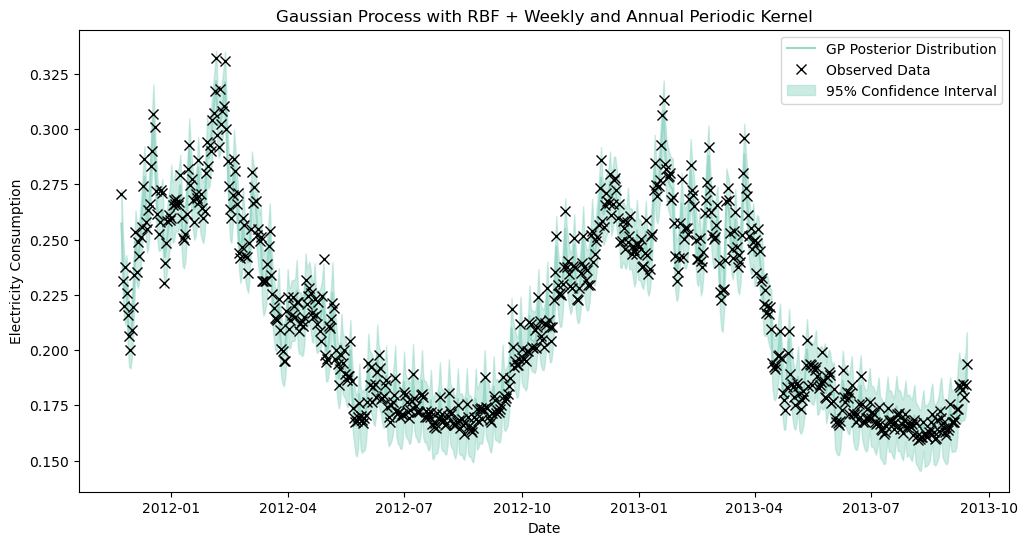

In [77]:
train_series.index = pd.to_datetime(train_series.index)
X = (train_series.index - train_series.index.min()).days.values.reshape(-1, 1)
y = np.array(train_series).reshape(-1, 1)

y_mean = y.mean()
y_std = y.std()
y_normalized = (y - y_mean) / y_std

# k_rbf = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=10)
# k_periodic = GPy.kern.PeriodicExponential(input_dim=1, variance=1, lengthscale=10, period=7)
# k_periodic2 = GPy.kern.PeriodicExponential(input_dim=1, variance=1, lengthscale=50, period=365)
# kernel = k_rbf + k_periodic * k_periodic2

k_rbf = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=50.0)
k_periodic = GPy.kern.StdPeriodic(input_dim=1, variance=0.7, lengthscale=20.0, period=7)
k_periodic2 = GPy.kern.StdPeriodic(input_dim=1, variance=0.7, lengthscale=30.0, period=365)
kernel = k_rbf + k_periodic + k_periodic2

model = GPy.models.GPRegression(X, y_normalized, kernel)
model.optimize(messages=True, max_iters=300)

y_pred_mean, y_var = model.predict(X)
y_pred_mean = y_pred_mean * y_std + y_mean
y_pred_std = np.sqrt(y_var) * y_std

log_likelihood = model.log_likelihood()
num_parameters = len(model.param_array)  
aic = 2 * num_parameters - 2 * log_likelihood

print(f"Log-Likelihood: {log_likelihood:.4f}")
print(f"AIC: {aic:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(train_series.index, y_pred_mean, color='#99d8c9', label='GP Posterior Distribution')
plt.plot(train_series.index, y, 'x', color='k', label='Observed Data', markersize=7)
plt.fill_between(
    train_series.index,
    (y_pred_mean - 2 * y_pred_std).flatten(),
    (y_pred_mean + 2 * y_pred_std).flatten(),
    color='#99d8c9',
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
# plt.ylim(0, 0.5)
plt.title('Gaussian Process with RBF + Weekly and Annual Periodic Kernel')
plt.show()

Test Mean Squared Error (MSE): 0.0002
Test Mean Absolute Percentage Error (MAPE): 5.86%


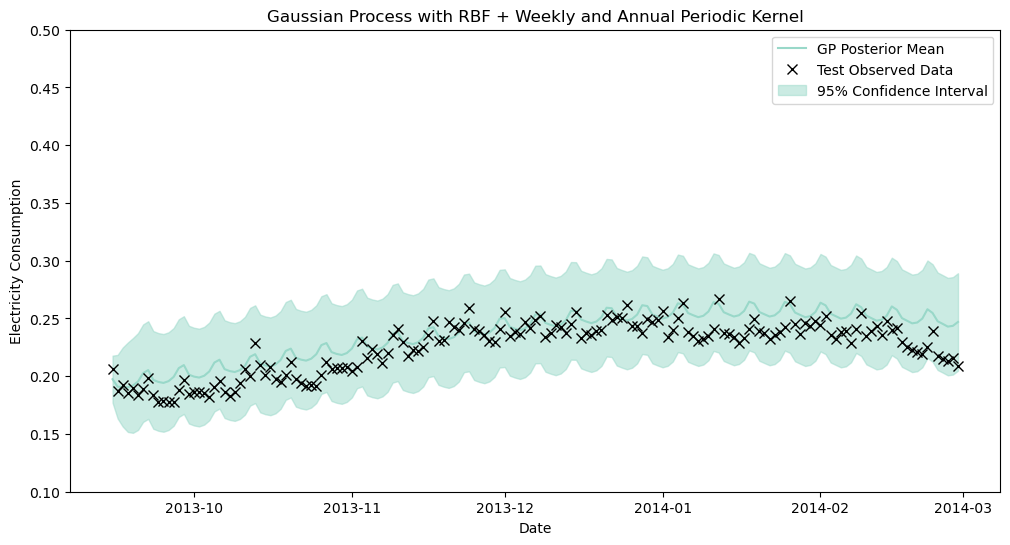

In [78]:
test_series = test_data_daily.set_index('date')['y']

test_series.index = pd.to_datetime(test_series.index)
X_test = (test_series.index - train_series.index.min()).days.values.reshape(-1, 1)
y_test = np.array(test_series).reshape(-1, 1)

y_pred_test, y_var_test = model.predict(X_test)
y_pred_test = y_pred_test * y_std + y_mean
y_std_test = np.sqrt(y_var_test) * y_std

mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print(f"Test Mean Squared Error (MSE): {mse_test:.4f}")
print(f"Test Mean Absolute Percentage Error (MAPE): {mape_test:.2%}")

plt.figure(figsize=(12, 6))
plt.plot(test_series.index, y_pred_test, color='#99d8c9', label='GP Posterior Mean')
plt.plot(test_series.index, y_test, 'x', color='k', label='Test Observed Data', markersize=7)
plt.fill_between(
    test_series.index,
    (y_pred_test - 2 * y_std_test).flatten(),
    (y_pred_test + 2 * y_std_test).flatten(),
    color='#99d8c9',
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.ylim(0.1, 0.5)
plt.title('Gaussian Process with RBF + Weekly and Annual Periodic Kernel')
plt.show()

The Gaussian Process with RBF + Weekly and Annual Period Kernel also showed very good results capturing the two seasonalities and showing great forecast performance.